# Analyzing Cryptocurrency Prices Using Google Trends

## Preparing Data 

In [1]:
import pandas as pd
import numpy as np 
from pandas import ExcelWriter
%matplotlib inline

In [2]:
from datetime import datetime 
import time 

btc_df = pd.read_csv('../data/BTC/BTC_2012_2018_06_1min.csv')
btc_df["Date(UTC)"] = pd.to_datetime(btc_df["Timestamp"], utc=True,unit='s')

In [3]:
# Import Bitcoin Trend Overlap Data

# google_trends_overlap_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_overlap_v2.csv', encoding='latin1')
# google_trends_overlap_df["date"] = pd.to_datetime(google_trends_overlap_df["date"])
# google_trends_overlap_df['date original'] = google_trends_overlap_df['date']
# # The actual date is in EST, so add 5 hours to it to become UTC 
# #google_trends_overlap_df['Date_v2'] = google_trends_overlap_df['date'].dt.tz_localize('UTC').dt.tz_convert('Etc/GMT+5')
# google_trends_overlap_df['Date_v2'] = google_trends_overlap_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')

# # for some reason above assigns the adjusted time to date 

# #google_trends_overlap_df['Date_UTC_trend'] = google_trends_overlap_df['date'].dt.tz_localize('UTC')
# #google_trends_overlap_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_overlap_df.date]

# google_trends_overlap_df["Timestamp"] = google_trends_overlap_df['date'].astype(np.int64)// 10**9

# google_trends_overlap_df = google_trends_overlap_df[google_trends_overlap_df['Bitcoin'] != 0 ]
# google_trends_overlap_df['Bitcoin (Unadj.)'] = google_trends_overlap_df['Bitcoin']

google_trends_overlap_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_updated_8_20.csv', encoding='latin1')
google_trends_overlap_df["date"] = pd.to_datetime(google_trends_overlap_df["date"])
google_trends_overlap_df['Date_UTC_trend'] = google_trends_overlap_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
#google_trends_overlap_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_overlap_df.Date_UTC_trend]
google_trends_overlap_df["Timestamp"] = google_trends_overlap_df['Date_UTC_trend'].astype(np.int64)// 10**9
google_trends_overlap_df = google_trends_overlap_df[google_trends_overlap_df['Bitcoin'] != 0 ]
google_trends_overlap_df['Bitcoin (Unadj.)'] = google_trends_overlap_df['Bitcoin']


display(google_trends_overlap_df.head())

date  Bitcoin  isPartial            Date_UTC_trend  \
0 2015-01-06 00:00:00       79      False 2015-01-06 05:00:00+00:00   
1 2015-01-06 01:00:00       63      False 2015-01-06 06:00:00+00:00   
2 2015-01-06 02:00:00       67      False 2015-01-06 07:00:00+00:00   
3 2015-01-06 03:00:00       57      False 2015-01-06 08:00:00+00:00   
4 2015-01-06 04:00:00       56      False 2015-01-06 09:00:00+00:00   

    Timestamp  Bitcoin (Unadj.)  
0  1420520400                79  
1  1420524000                63  
2  1420527600                67  
3  1420531200                57  
4  1420534800                56

In [4]:
# Adjust Bitcoin Trend Using Overlap Data

def weigh_using_overlap(row, overlap_df, duplicate_df, ratios):
    if ( (row['Timestamp'] < duplicate_df['Timestamp'].iloc[0])): #or (row['Timestamp'] > duplicate_df['Timestamp'].iloc[-1])): 
        # edge case for first week
        return row['Bitcoin']
    else:
        try: 
            row_index = int(row.name) 
            if (row['Timestamp'] == overlap_df['Timestamp'].loc[row_index+1] ):
                # first occurence of the duplicate     
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp'] - 3600 ]
                if (len(duplicate_truncated_df) == 0 ): 
                    # very first duplicate, return as is 
                    #print('very first duplicate')
                    return row['Bitcoin']
            else:
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp']]
            ratio = float(duplicate_truncated_df.iloc[-2]['Bitcoin']) / float(duplicate_truncated_df.iloc[-1]['Bitcoin'])
            if (len(ratios) == 0):
                # first row 
                ratios.append(ratio)
            if ( len( duplicate_truncated_df) < 2 ):
                # first week edge case
                #print('first week')
                return row['Bitcoin'] 
            if ( (row['Timestamp'] == duplicate_truncated_df.iloc[-1]['Timestamp']) and (ratio != ratios[-1])  ):
                # ratio just changed 
                ratios.append(ratio*ratios[-1])
                #print('previous ratio: ', ratios[-2])
                #print('result ratio: ', ratios[-1] )
                return row['Bitcoin'] * ratios[-1]
            else:
                #print('using ratio: ', ratios[-1] )
                return row['Bitcoin'] * ratios[-1]
        except Exception as e:
            #display(e)
            
            # TODO: Address the problem of rows with value of 0
            
            return None
        
occurence_duplicates = google_trends_overlap_df[google_trends_overlap_df.duplicated(['Timestamp'], keep=False)]

ratios = []
google_trends_overlap_df["Bitcoin"] = google_trends_overlap_df.apply(lambda row: weigh_using_overlap(row, google_trends_overlap_df, occurence_duplicates, ratios), axis=1)
google_trends_overlap_df.drop_duplicates(subset='date',keep='last',inplace=True)
google_trends_overlap_df = google_trends_overlap_df.rename(columns = {'Bitcoin':'Bitcoin (Adj.Overlap)'})

display(google_trends_overlap_df.head())

date  Bitcoin (Adj.Overlap)  isPartial  \
0 2015-01-06 00:00:00                   79.0      False   
1 2015-01-06 01:00:00                   63.0      False   
2 2015-01-06 02:00:00                   67.0      False   
3 2015-01-06 03:00:00                   57.0      False   
4 2015-01-06 04:00:00                   56.0      False   

             Date_UTC_trend   Timestamp  Bitcoin (Unadj.)  
0 2015-01-06 05:00:00+00:00  1420520400                79  
1 2015-01-06 06:00:00+00:00  1420524000                63  
2 2015-01-06 07:00:00+00:00  1420527600                67  
3 2015-01-06 08:00:00+00:00  1420531200                57  
4 2015-01-06 09:00:00+00:00  1420534800                56

In [5]:
# writer = pd.ExcelWriter("CryptoGoogleTrends_with_overlap_adjusted.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# google_trends_overlap_df.to_excel(writer)
# writer.save()

## Data Visualization

In [5]:
import matplotlib.pyplot as plt

btc_and_trends_df_hourly_overlap = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_overlap_df, right_on="Timestamp")
btc_and_trends_df_hourly_overlap["Close Price % Change"] = btc_and_trends_df_hourly_overlap["Close"].pct_change()
btc_and_trends_df_hourly_overlap["Close Price % Change (Abs)"] = abs(btc_and_trends_df_hourly_overlap["Close Price % Change"])

btc_and_trends_df_hourly_overlap.loc[btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"] == 0] = 1 

display(btc_and_trends_df_hourly_overlap.head(2))

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 17:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   53.0      False 2015-01-09 22:00:00+00:00   
1                   52.0      False 2015-01-09 23:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  
0                53                   NaN                         NaN  
1                52              0.010445                    0.010445

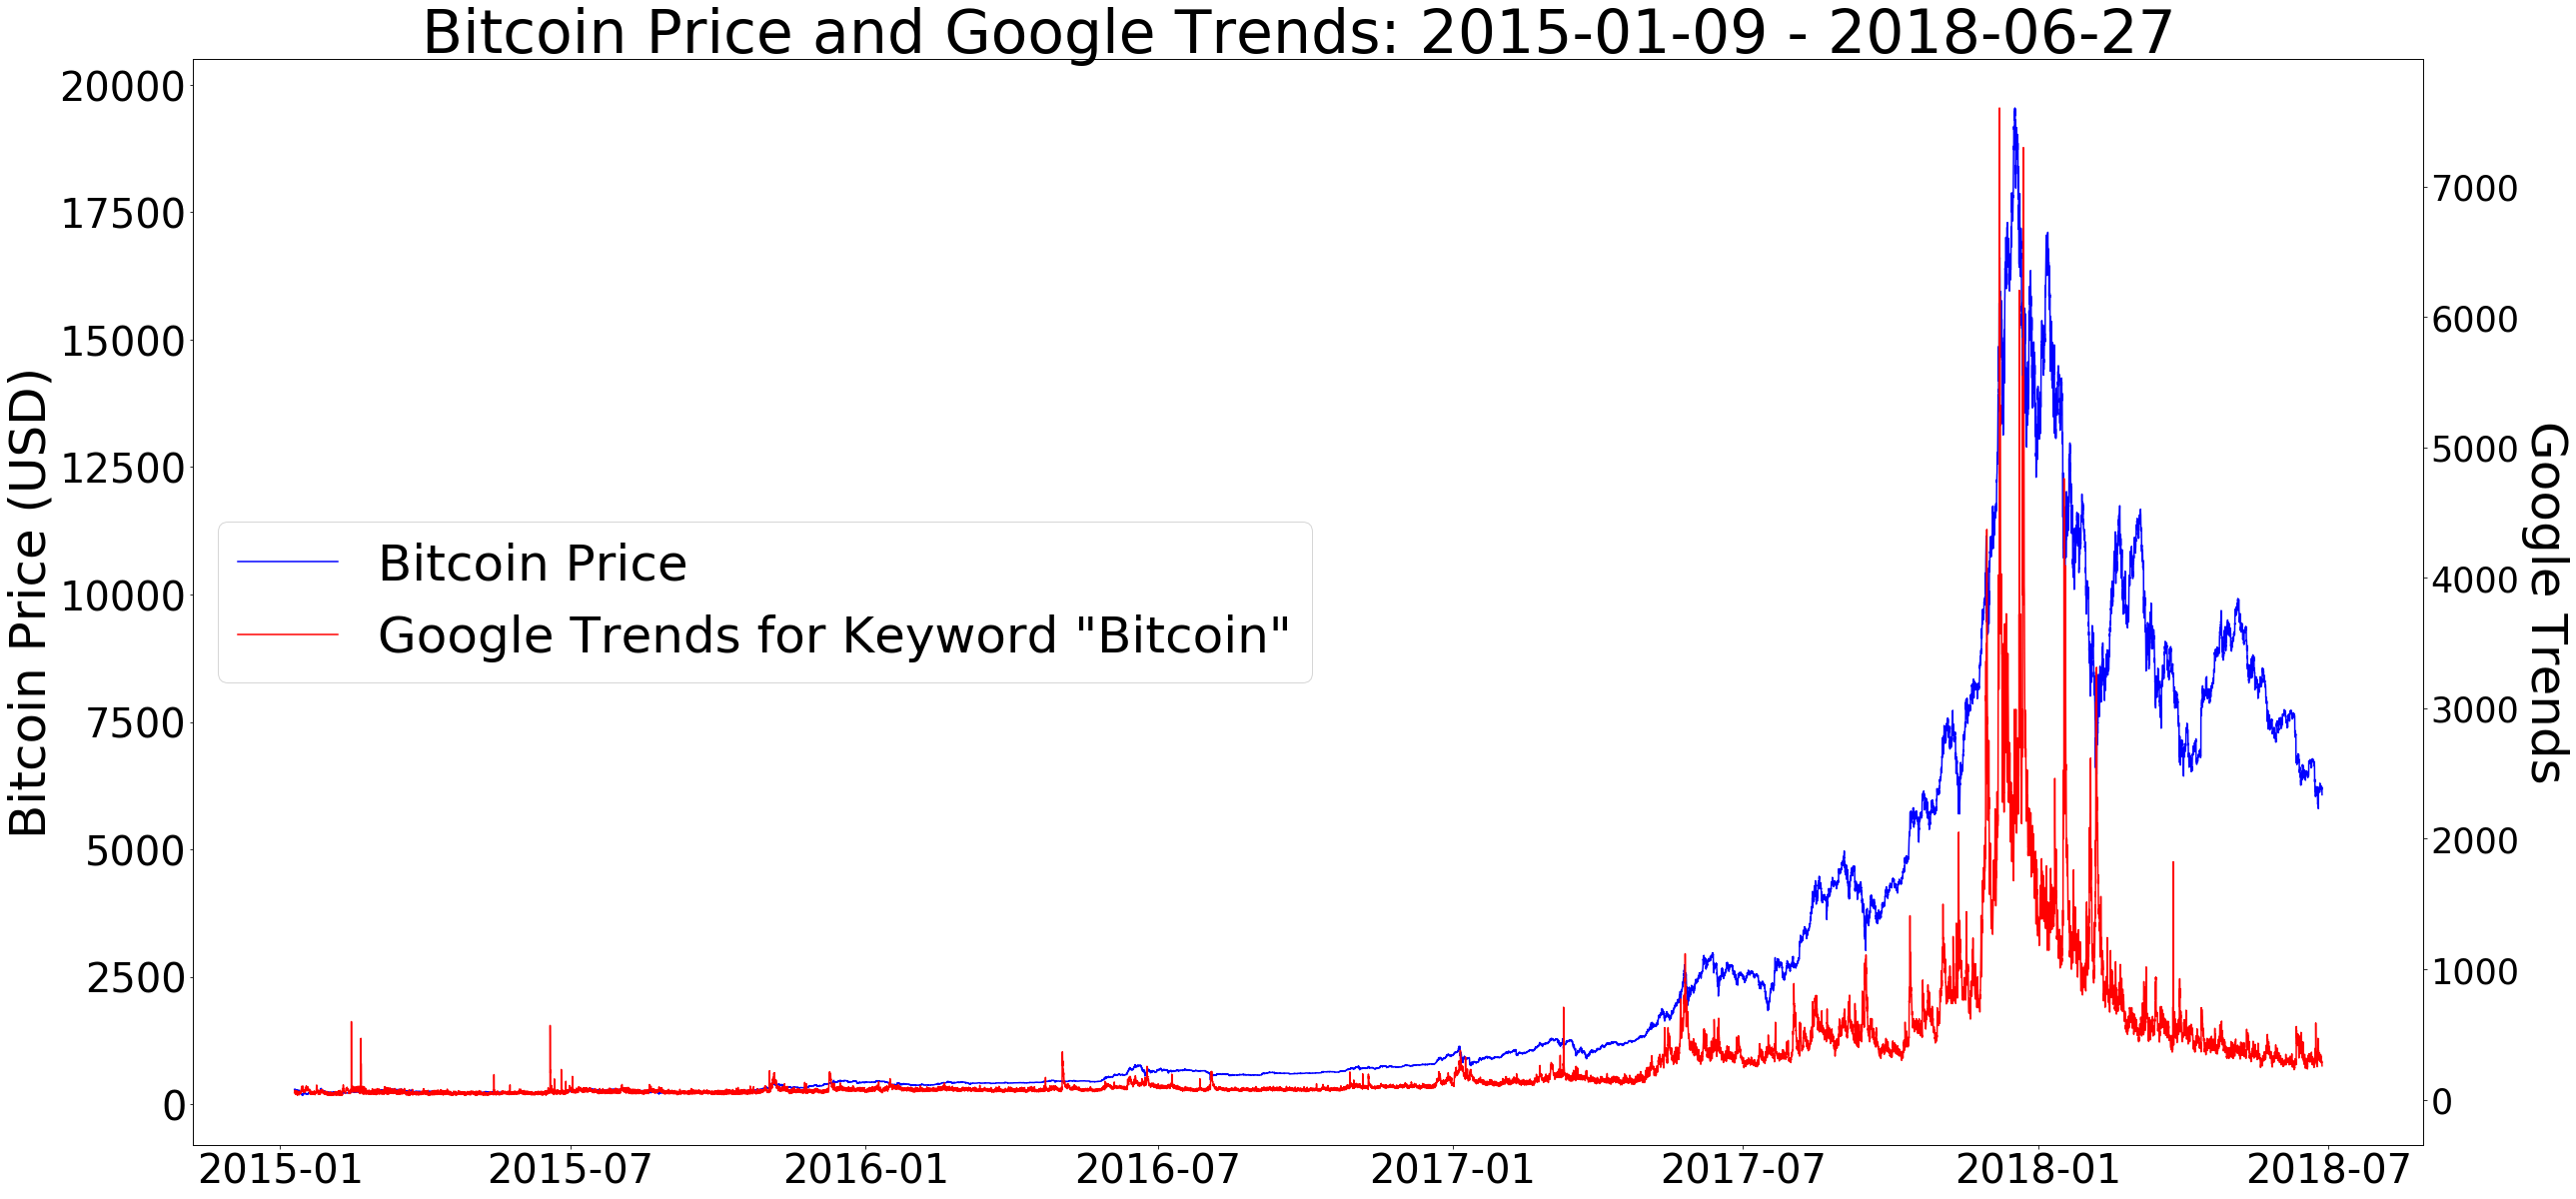

In [18]:
fig_bitcoin_overlap, ax_bitcoin_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_overlap.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close"], color='blue')
ax_bitcoin_overlap_2 = ax_bitcoin_overlap.twinx() 
l2, = ax_bitcoin_overlap_2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_overlap.set_title('Bitcoin Price and Google Trends: ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + '- ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=60)
for tick in ax_bitcoin_overlap.get_xticklabels():
    #tick.set_rotation(90)
    tick.set_fontsize(40) 
for tick in ax_bitcoin_overlap.get_yticklabels():
    tick.set_fontsize(40) 
#ax_bitcoin_overlap.set_xlabel("Date", fontsize=40)
ax_bitcoin_overlap.set_ylabel("Bitcoin Price (USD)",fontsize=50)
ax_bitcoin_overlap_2.set_ylabel("Google Trends\n",fontsize=50,rotation=270, labelpad=50)

plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Price", "Google Trends for Keyword \"Bitcoin\"" ], loc=6, fontsize=50)
plt.show();

In [7]:
# writer = pd.ExcelWriter("btc_and_trends_df_hourly_overlap.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# btc_and_trends_df_hourly_overlap.to_excel(writer)
# writer.save()

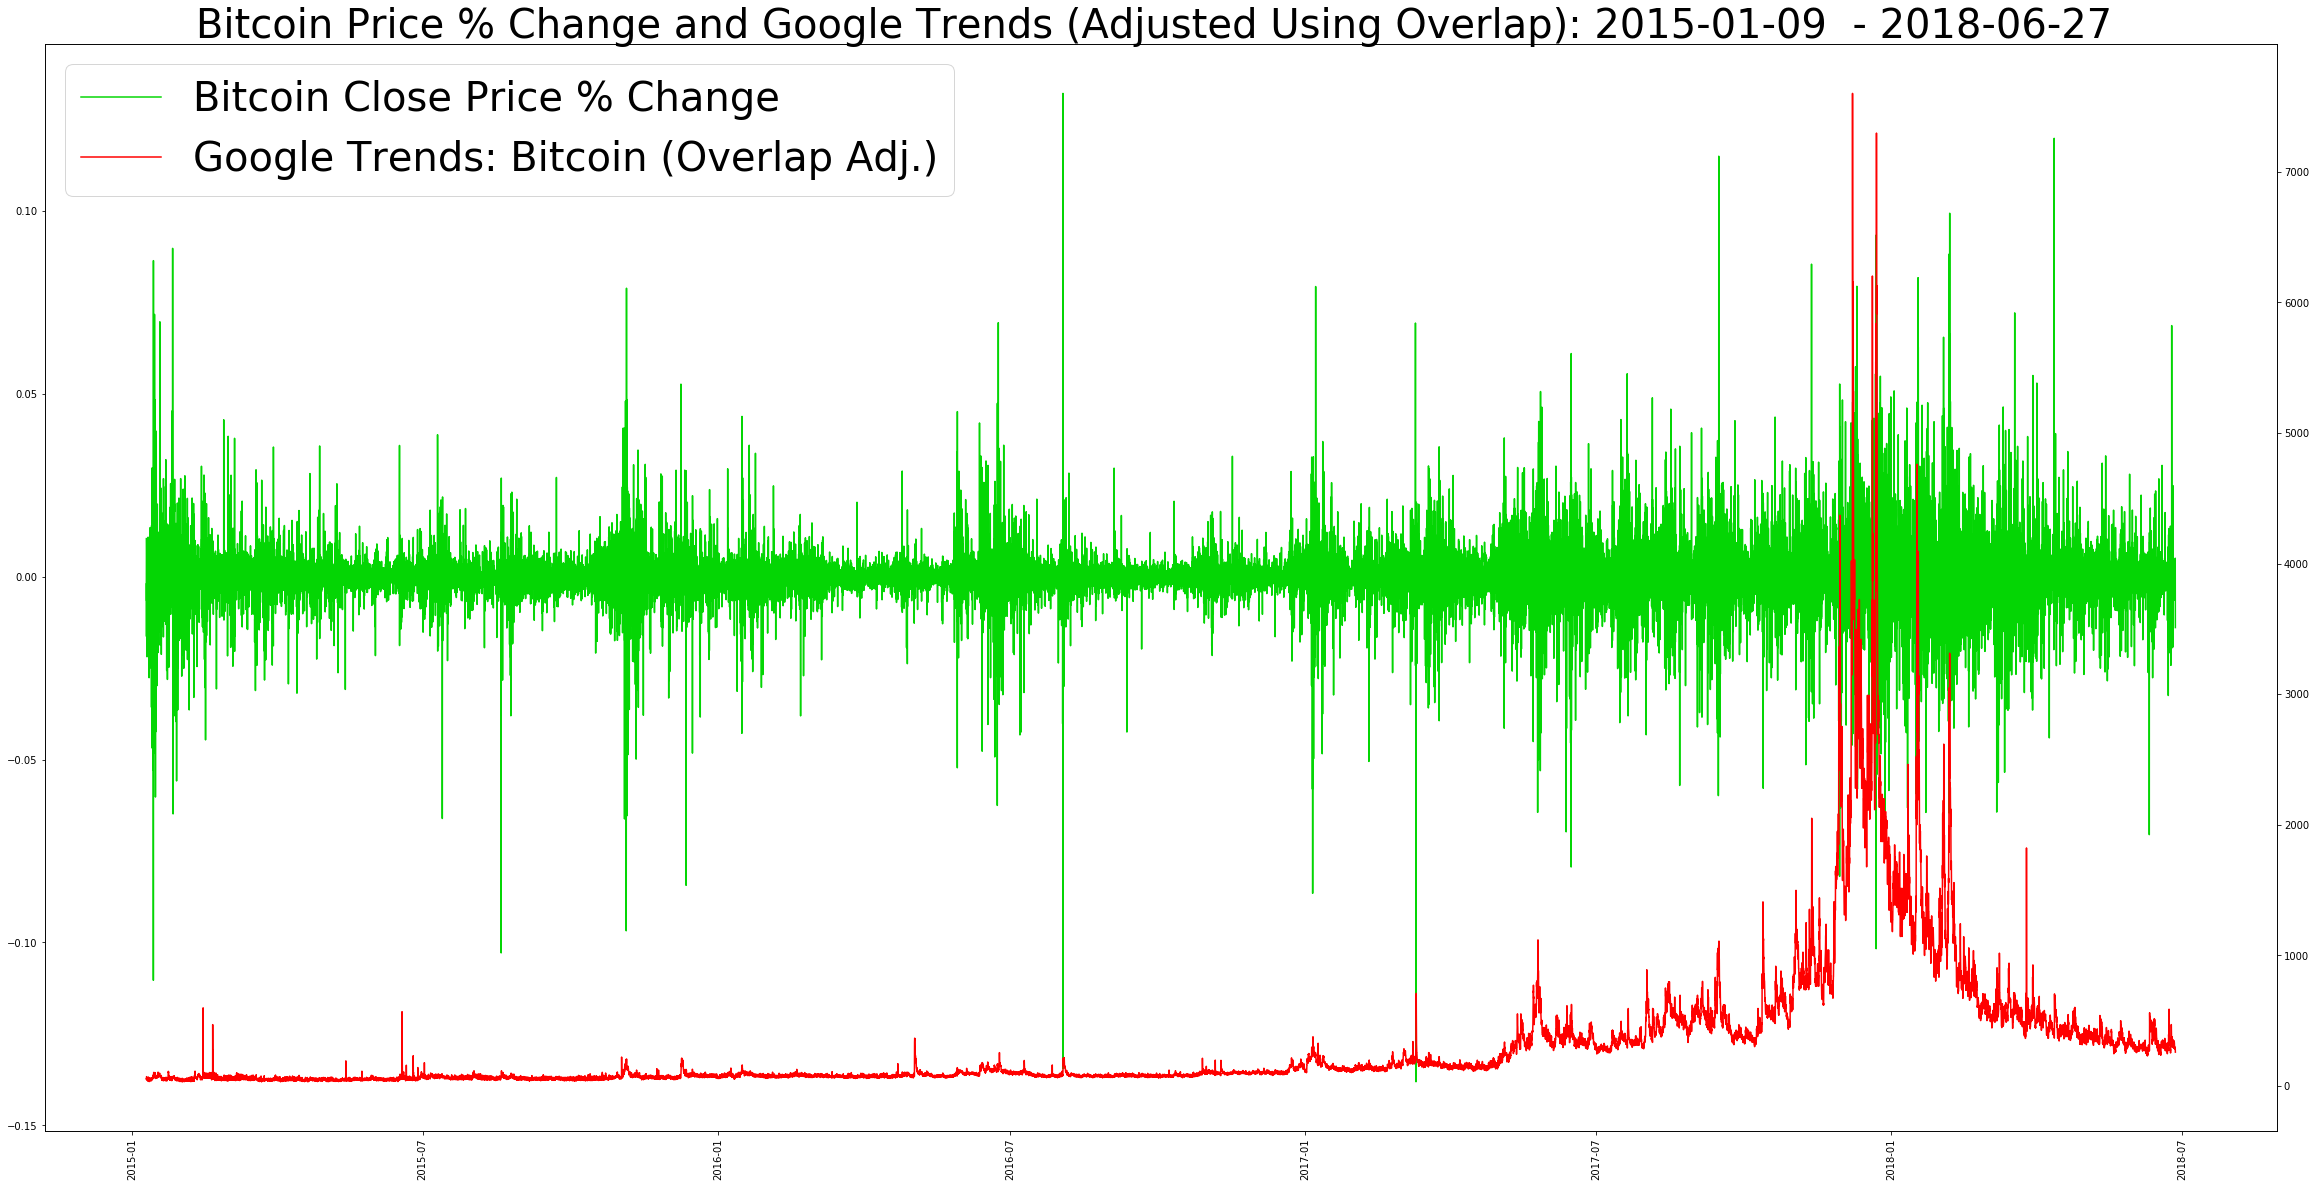

In [11]:
fig, ax = plt.subplots(figsize=(40,20)) 
light_green = '#04D604'
l1, = ax.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close Price % Change"], color=light_green)
ax2 = ax.twinx() 
l2, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax.set_title('Bitcoin Price % Change and Google Trends (Adjusted Using Overlap): ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Close Price % Change", "Google Trends: Bitcoin (Overlap Adj.)" ], fontsize=40)
plt.show();

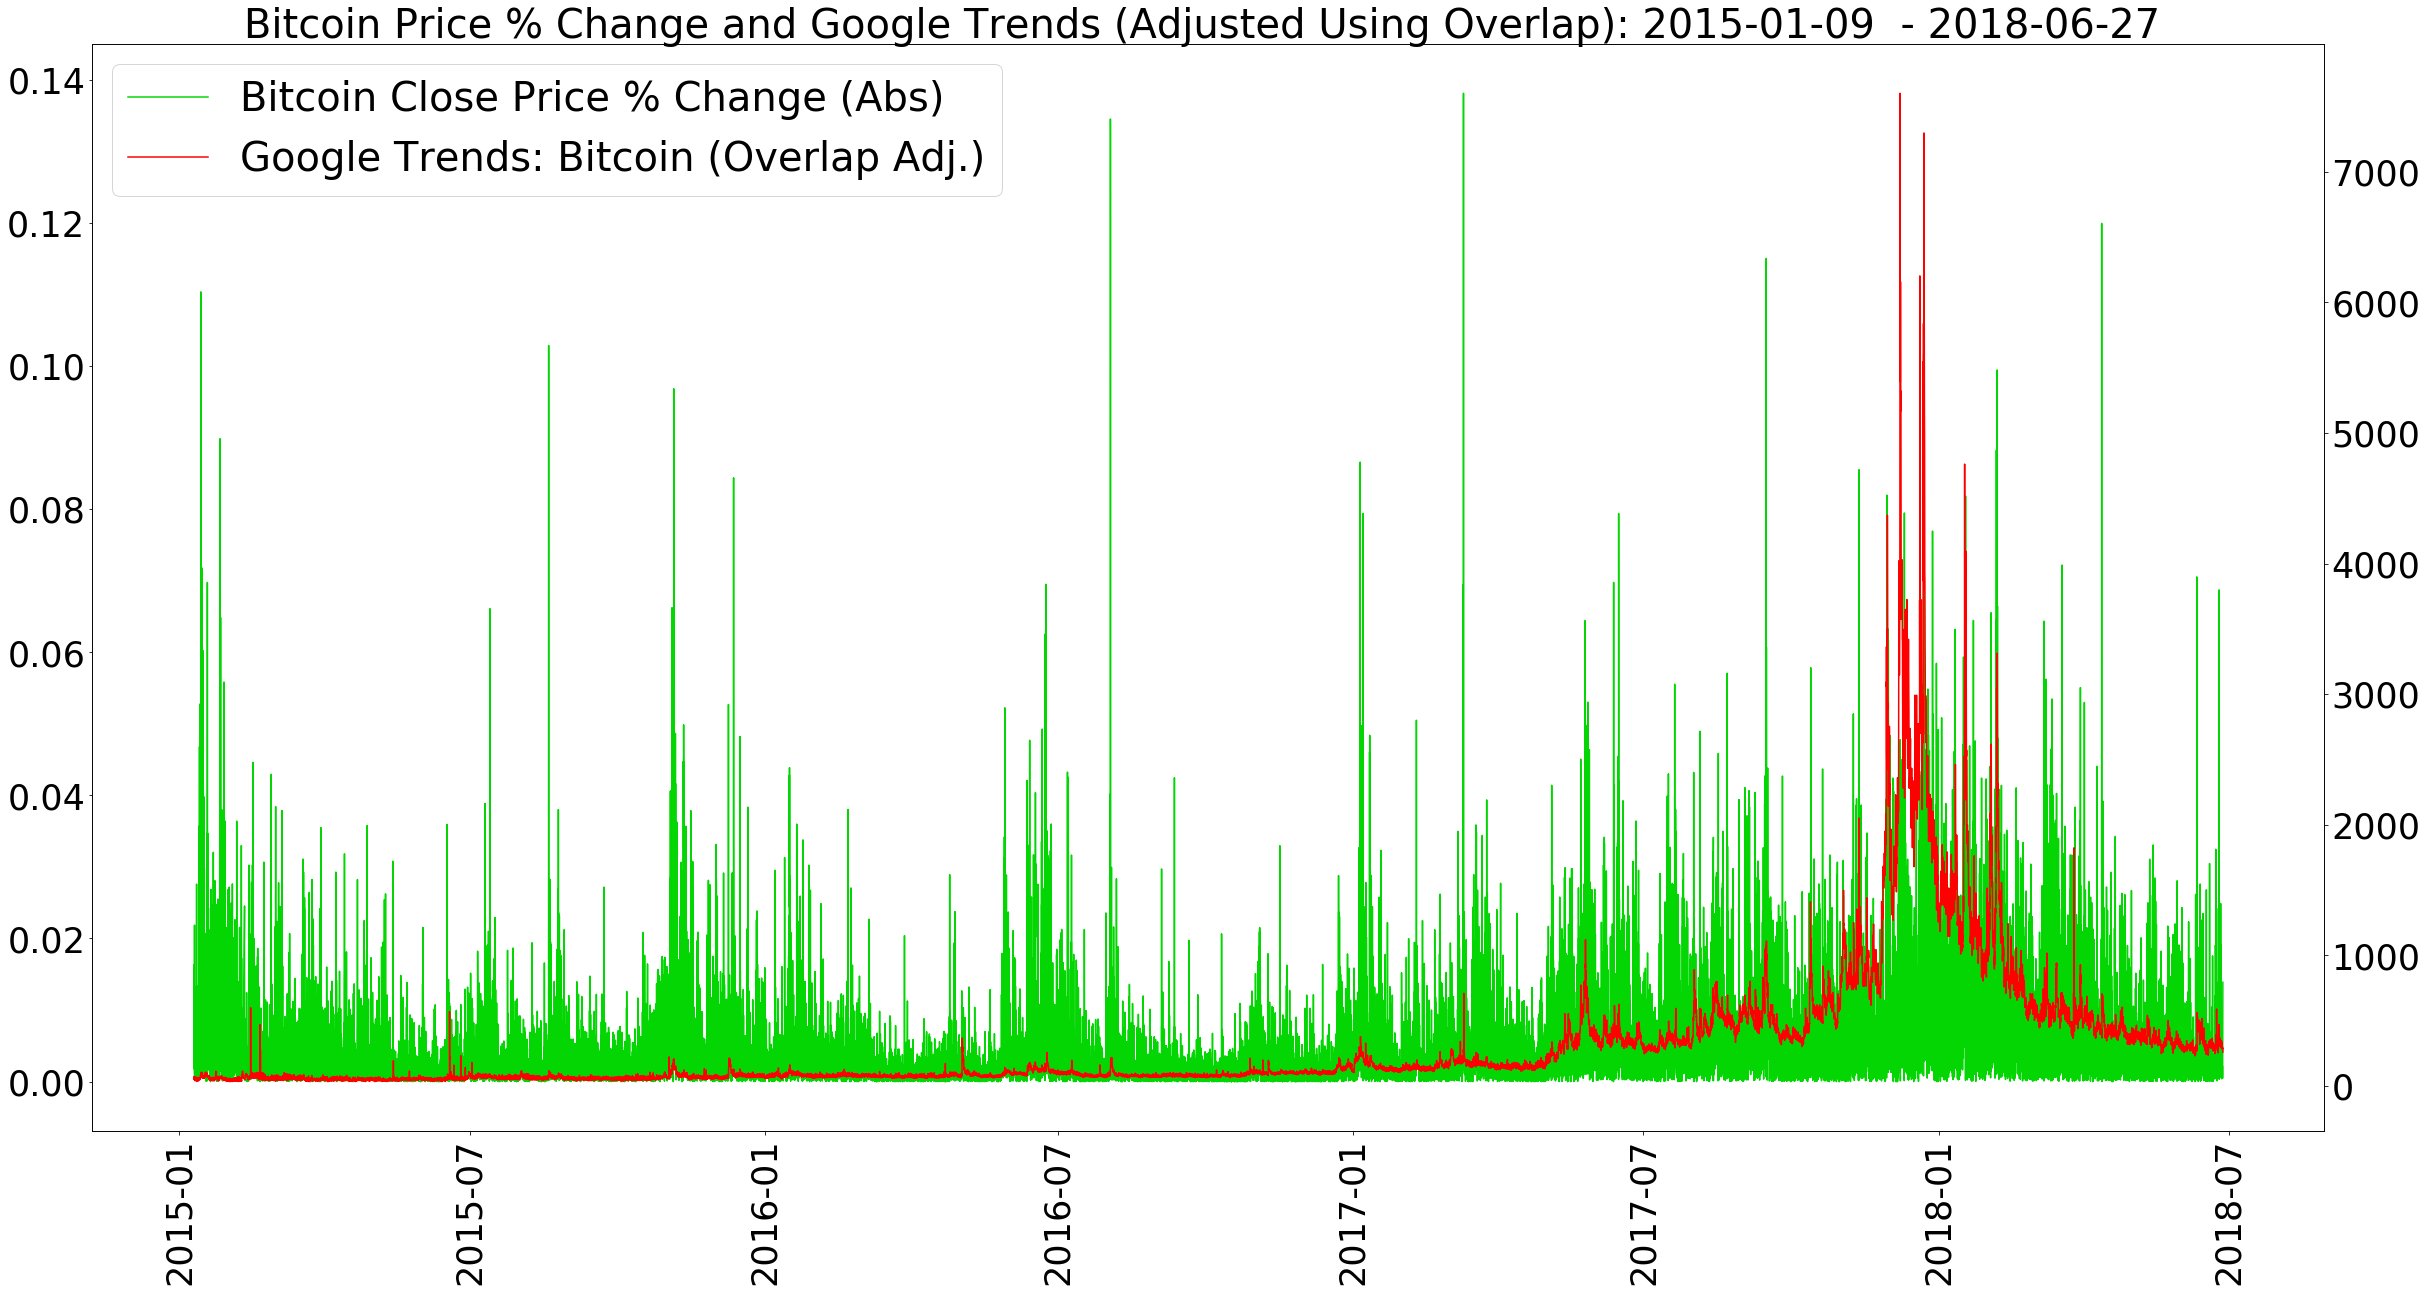

In [12]:
fig, ax = plt.subplots(figsize=(40,20)) 
l1, = ax.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close Price % Change (Abs)"], color=light_green)
ax2 = ax.twinx() 
l2, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax.set_title('Bitcoin Price % Change and Google Trends (Adjusted Using Overlap): ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Close Price % Change (Abs)", "Google Trends: Bitcoin (Overlap Adj.)" ], fontsize=40)
plt.show();

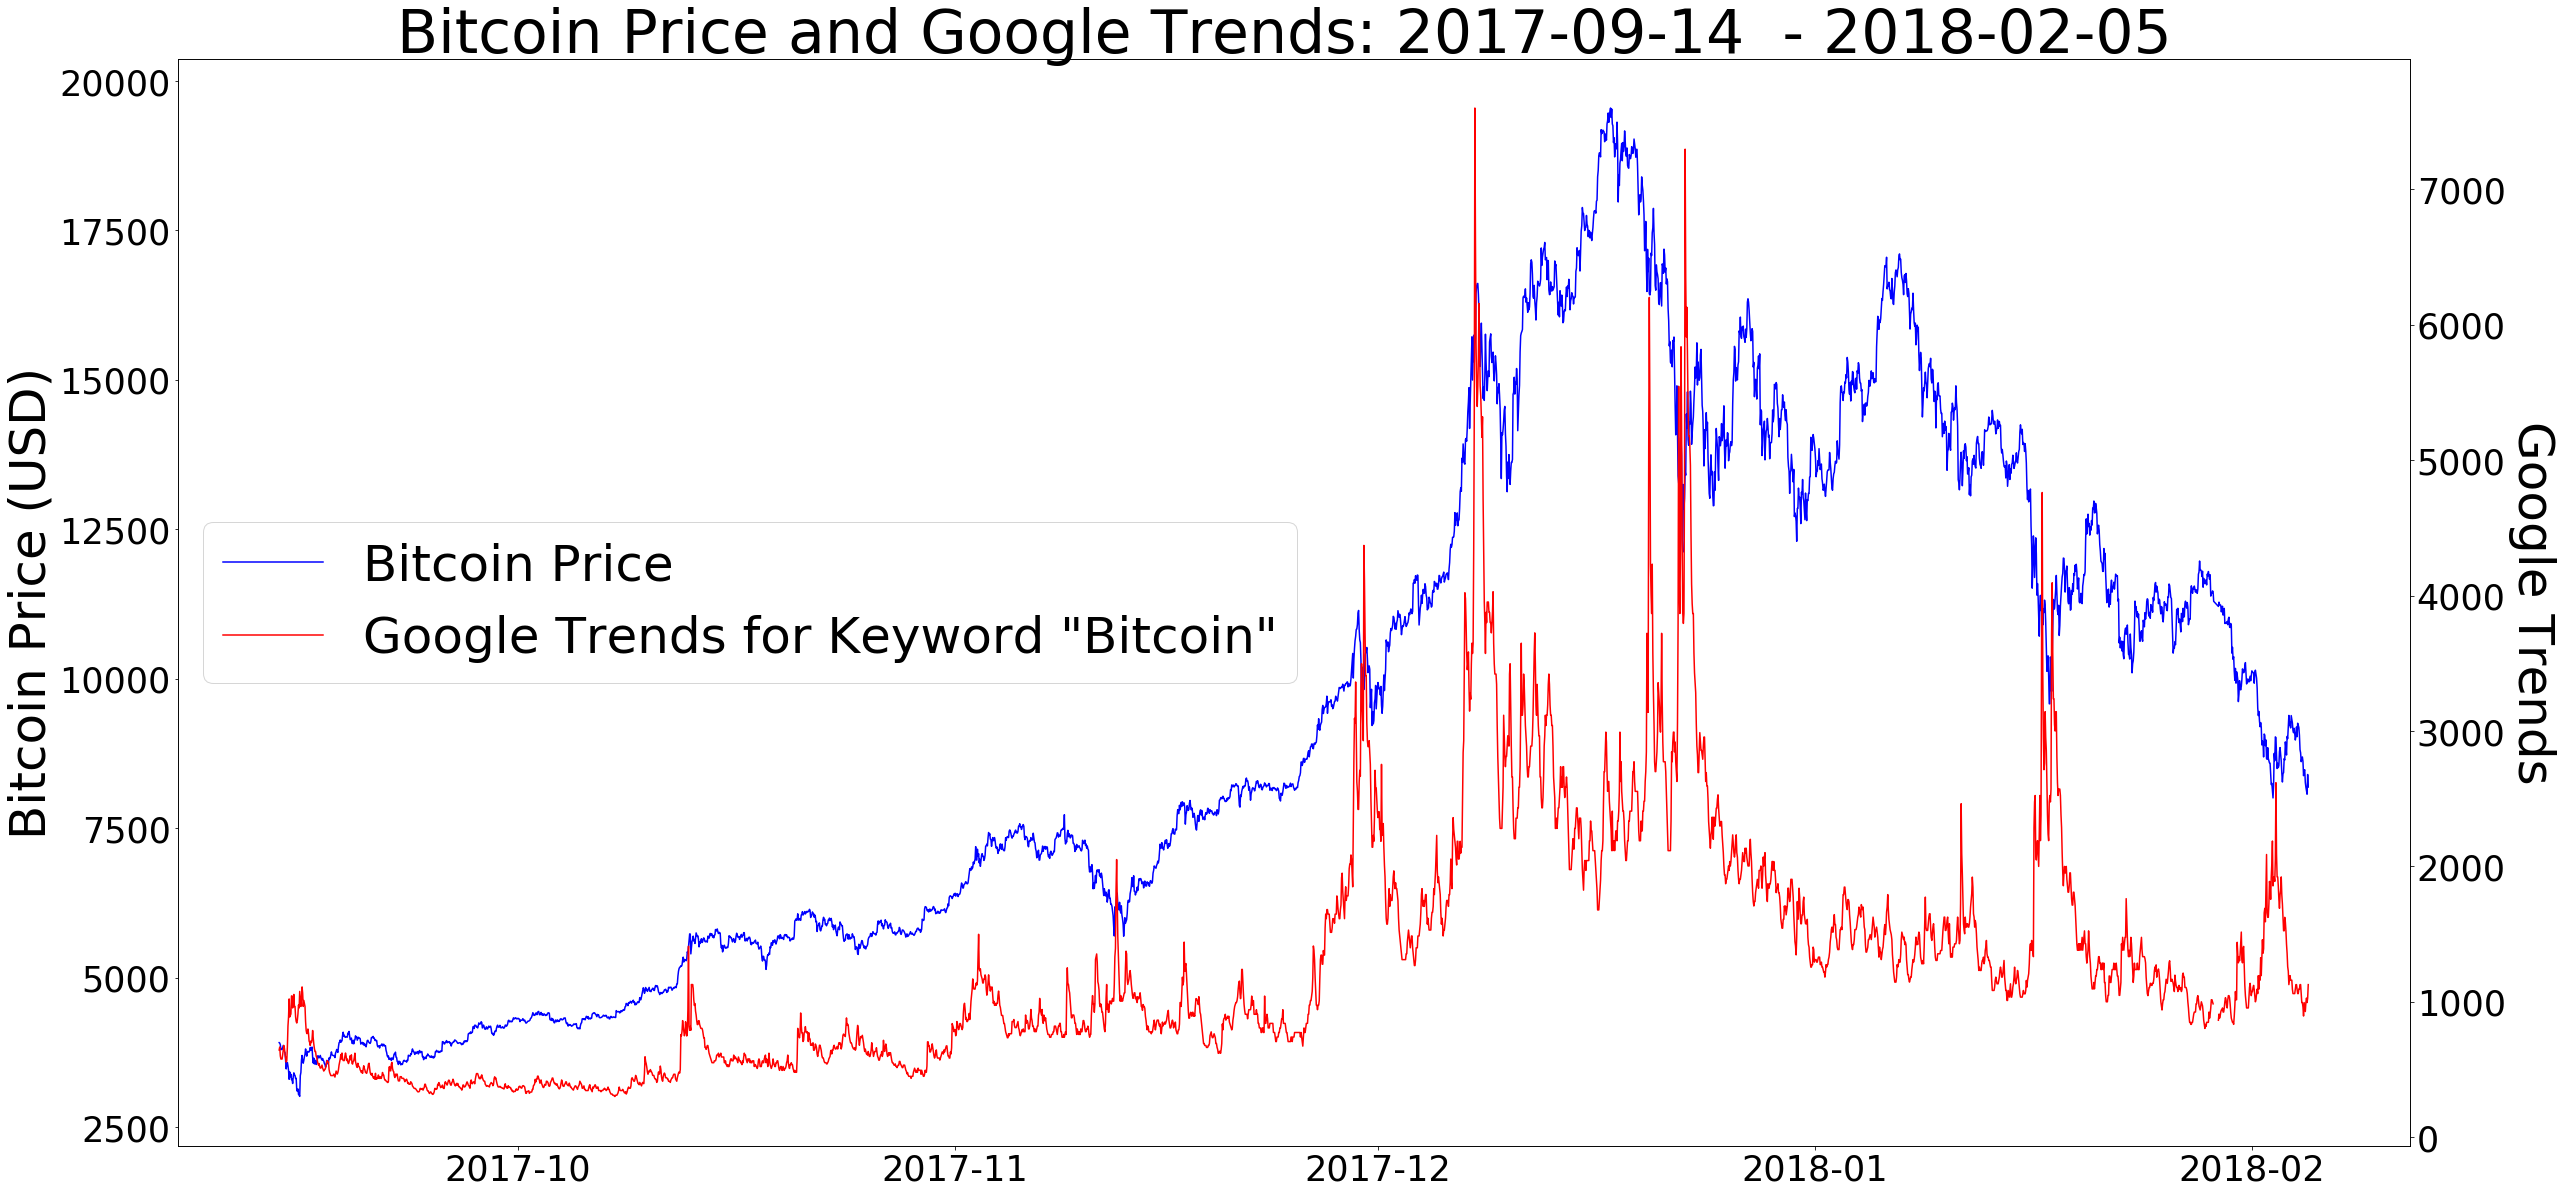

In [14]:
# visualize Bitcoin's recent super spike starting Sep 2017 using Overlap Adjusted Trend Data
sep_2017_to_feb_2018_overlap_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > 1505347200) & (btc_and_trends_df_hourly_overlap["Timestamp"] <=  1517788800) ]

fig_bitcoin_spike_overlap, ax_bitcoin_spike_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike_overlap.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Close"], color='blue')
ax_bitcoin_spike_overlap_2 = ax_bitcoin_spike_overlap.twinx() 
l2, = ax_bitcoin_spike_overlap_2.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_spike_overlap.set_title('Bitcoin Price and Google Trends: ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[-1])[:-8], fontsize=60 )
# for tick in ax_bitcoin_overlap.get_xticklabels():
#     tick.set_rotation(90)
#plt.rcParams.update({'font.size': 15})
ax_bitcoin_spike_overlap.set_ylabel("Bitcoin Price (USD)", size=50)
ax_bitcoin_spike_overlap_2.set_ylabel("Google Trends", size=50, rotation=270, labelpad=50)
plt.legend([l1, l2],["Bitcoin Price", "Google Trends for Keyword \"Bitcoin\""], loc=6, fontsize=50)
plt.show();

# blue is price, red is Overlap adjusted data

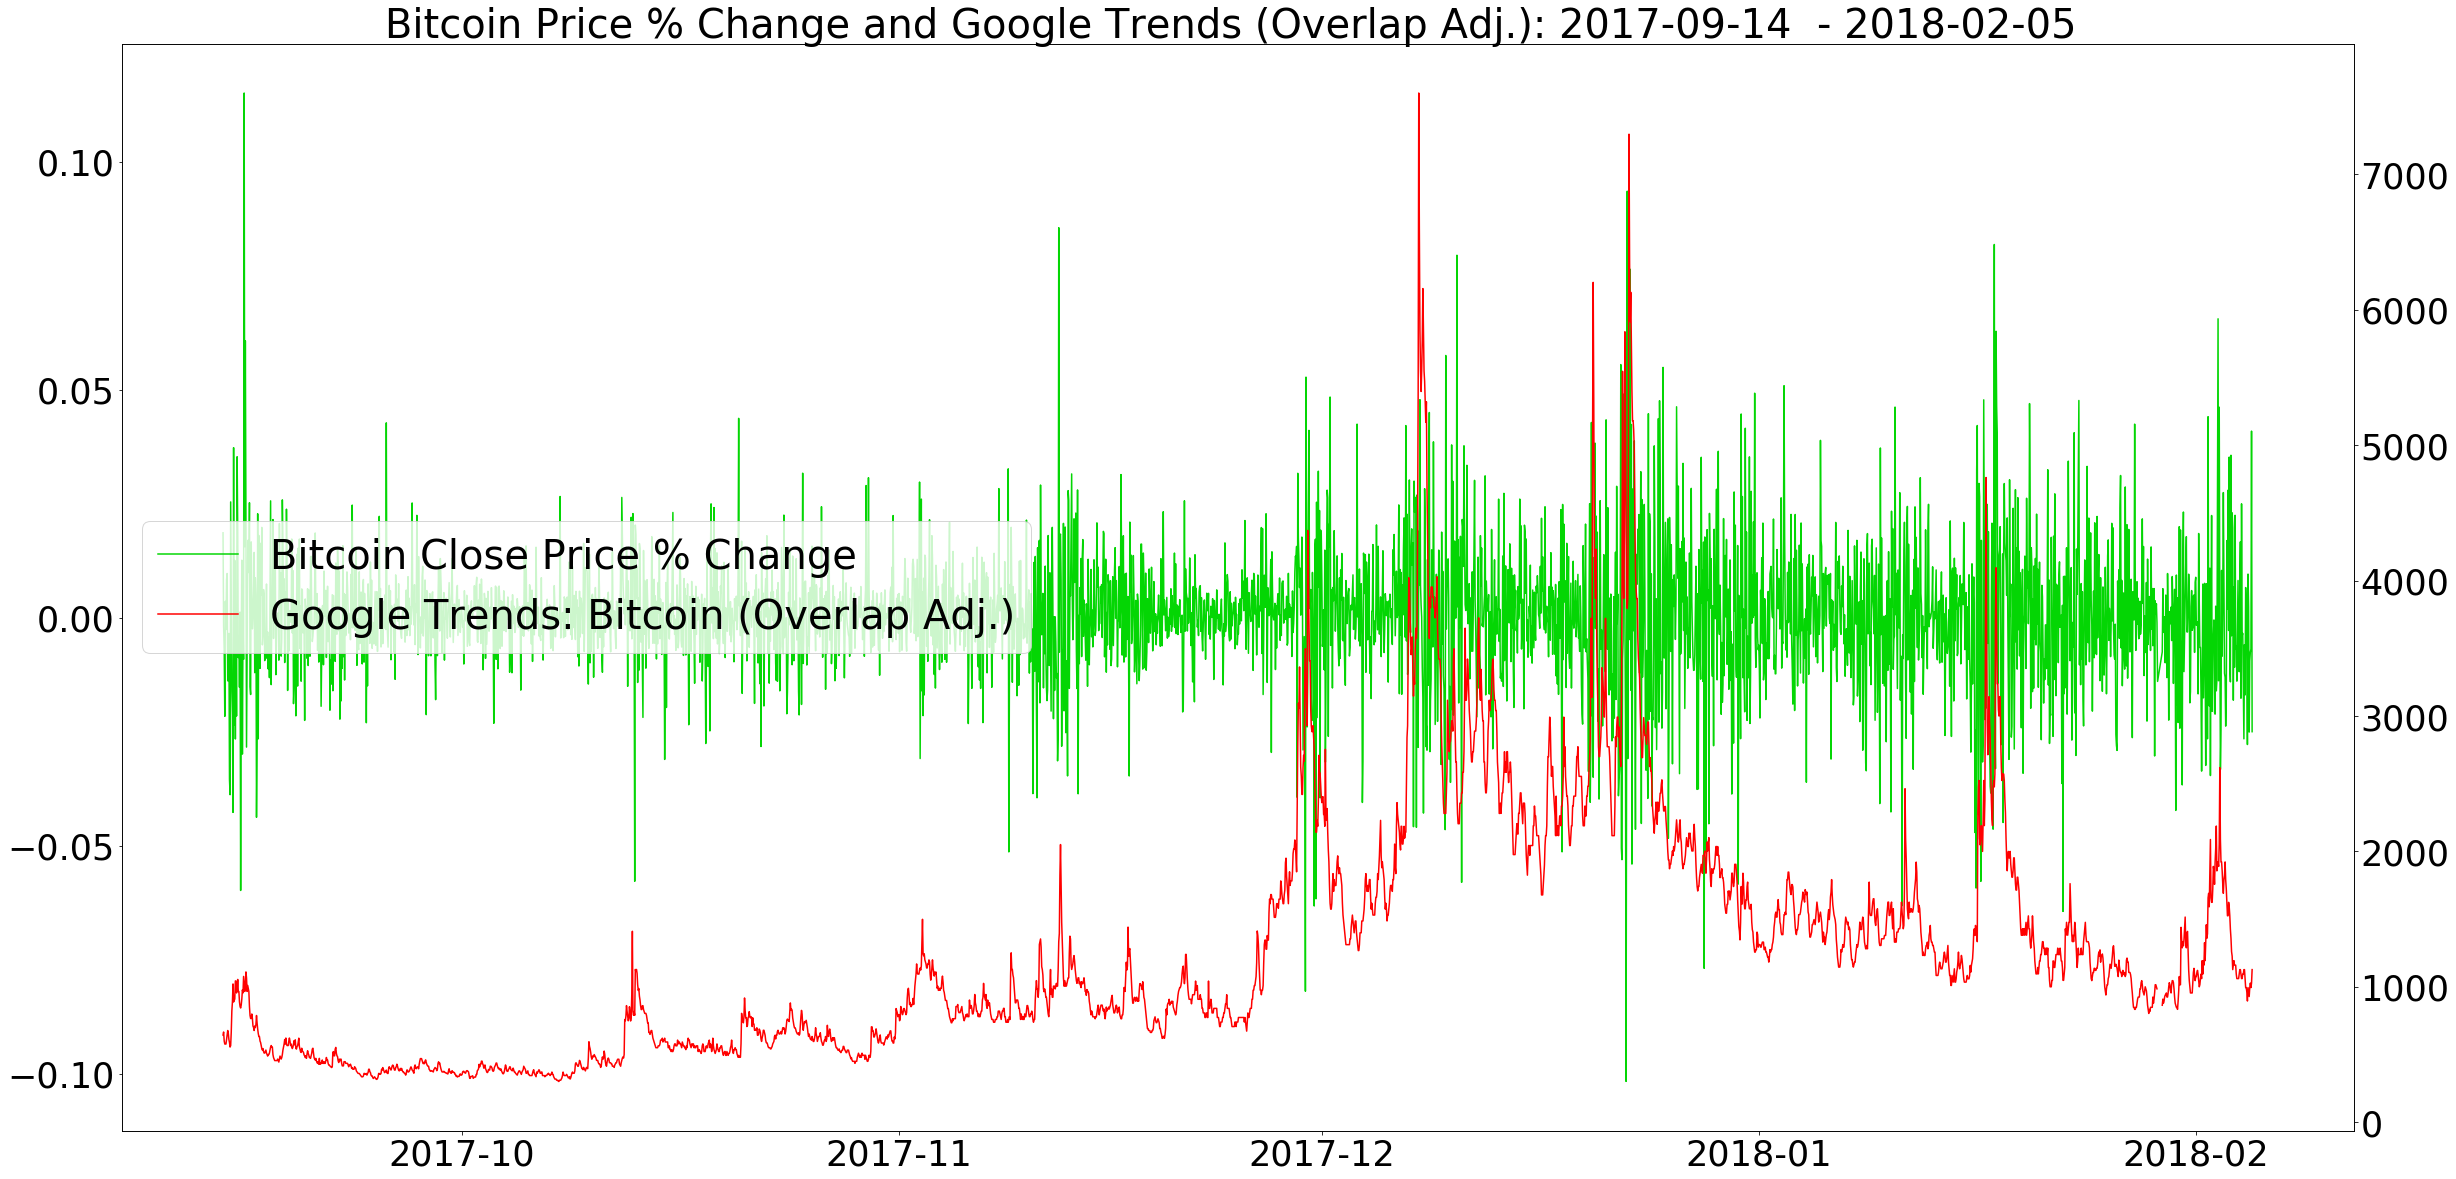

In [13]:
# visualize Bitcoin's recent super spike starting Sep 2017 using Overlap Adjusted Trend Data

fig_bitcoin_spike_overlap, ax_bitcoin_spike_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike_overlap.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Close Price % Change"], color=light_green)
ax_bitcoin_spike_overlap_2 = ax_bitcoin_spike_overlap.twinx() 
l2, = ax_bitcoin_spike_overlap_2.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_spike_overlap.set_title('Bitcoin Price % Change and Google Trends (Overlap Adj.): ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax_bitcoin_overlap.get_xticklabels():
    tick.set_rotation(90)
#plt.rcParams.update({'font.size': 15})
plt.legend([l1, l2],["Bitcoin Close Price % Change", "Google Trends: Bitcoin (Overlap Adj.)"], loc=6, fontsize=40)
plt.show();

# blue is price, red is Overlap adjusted data

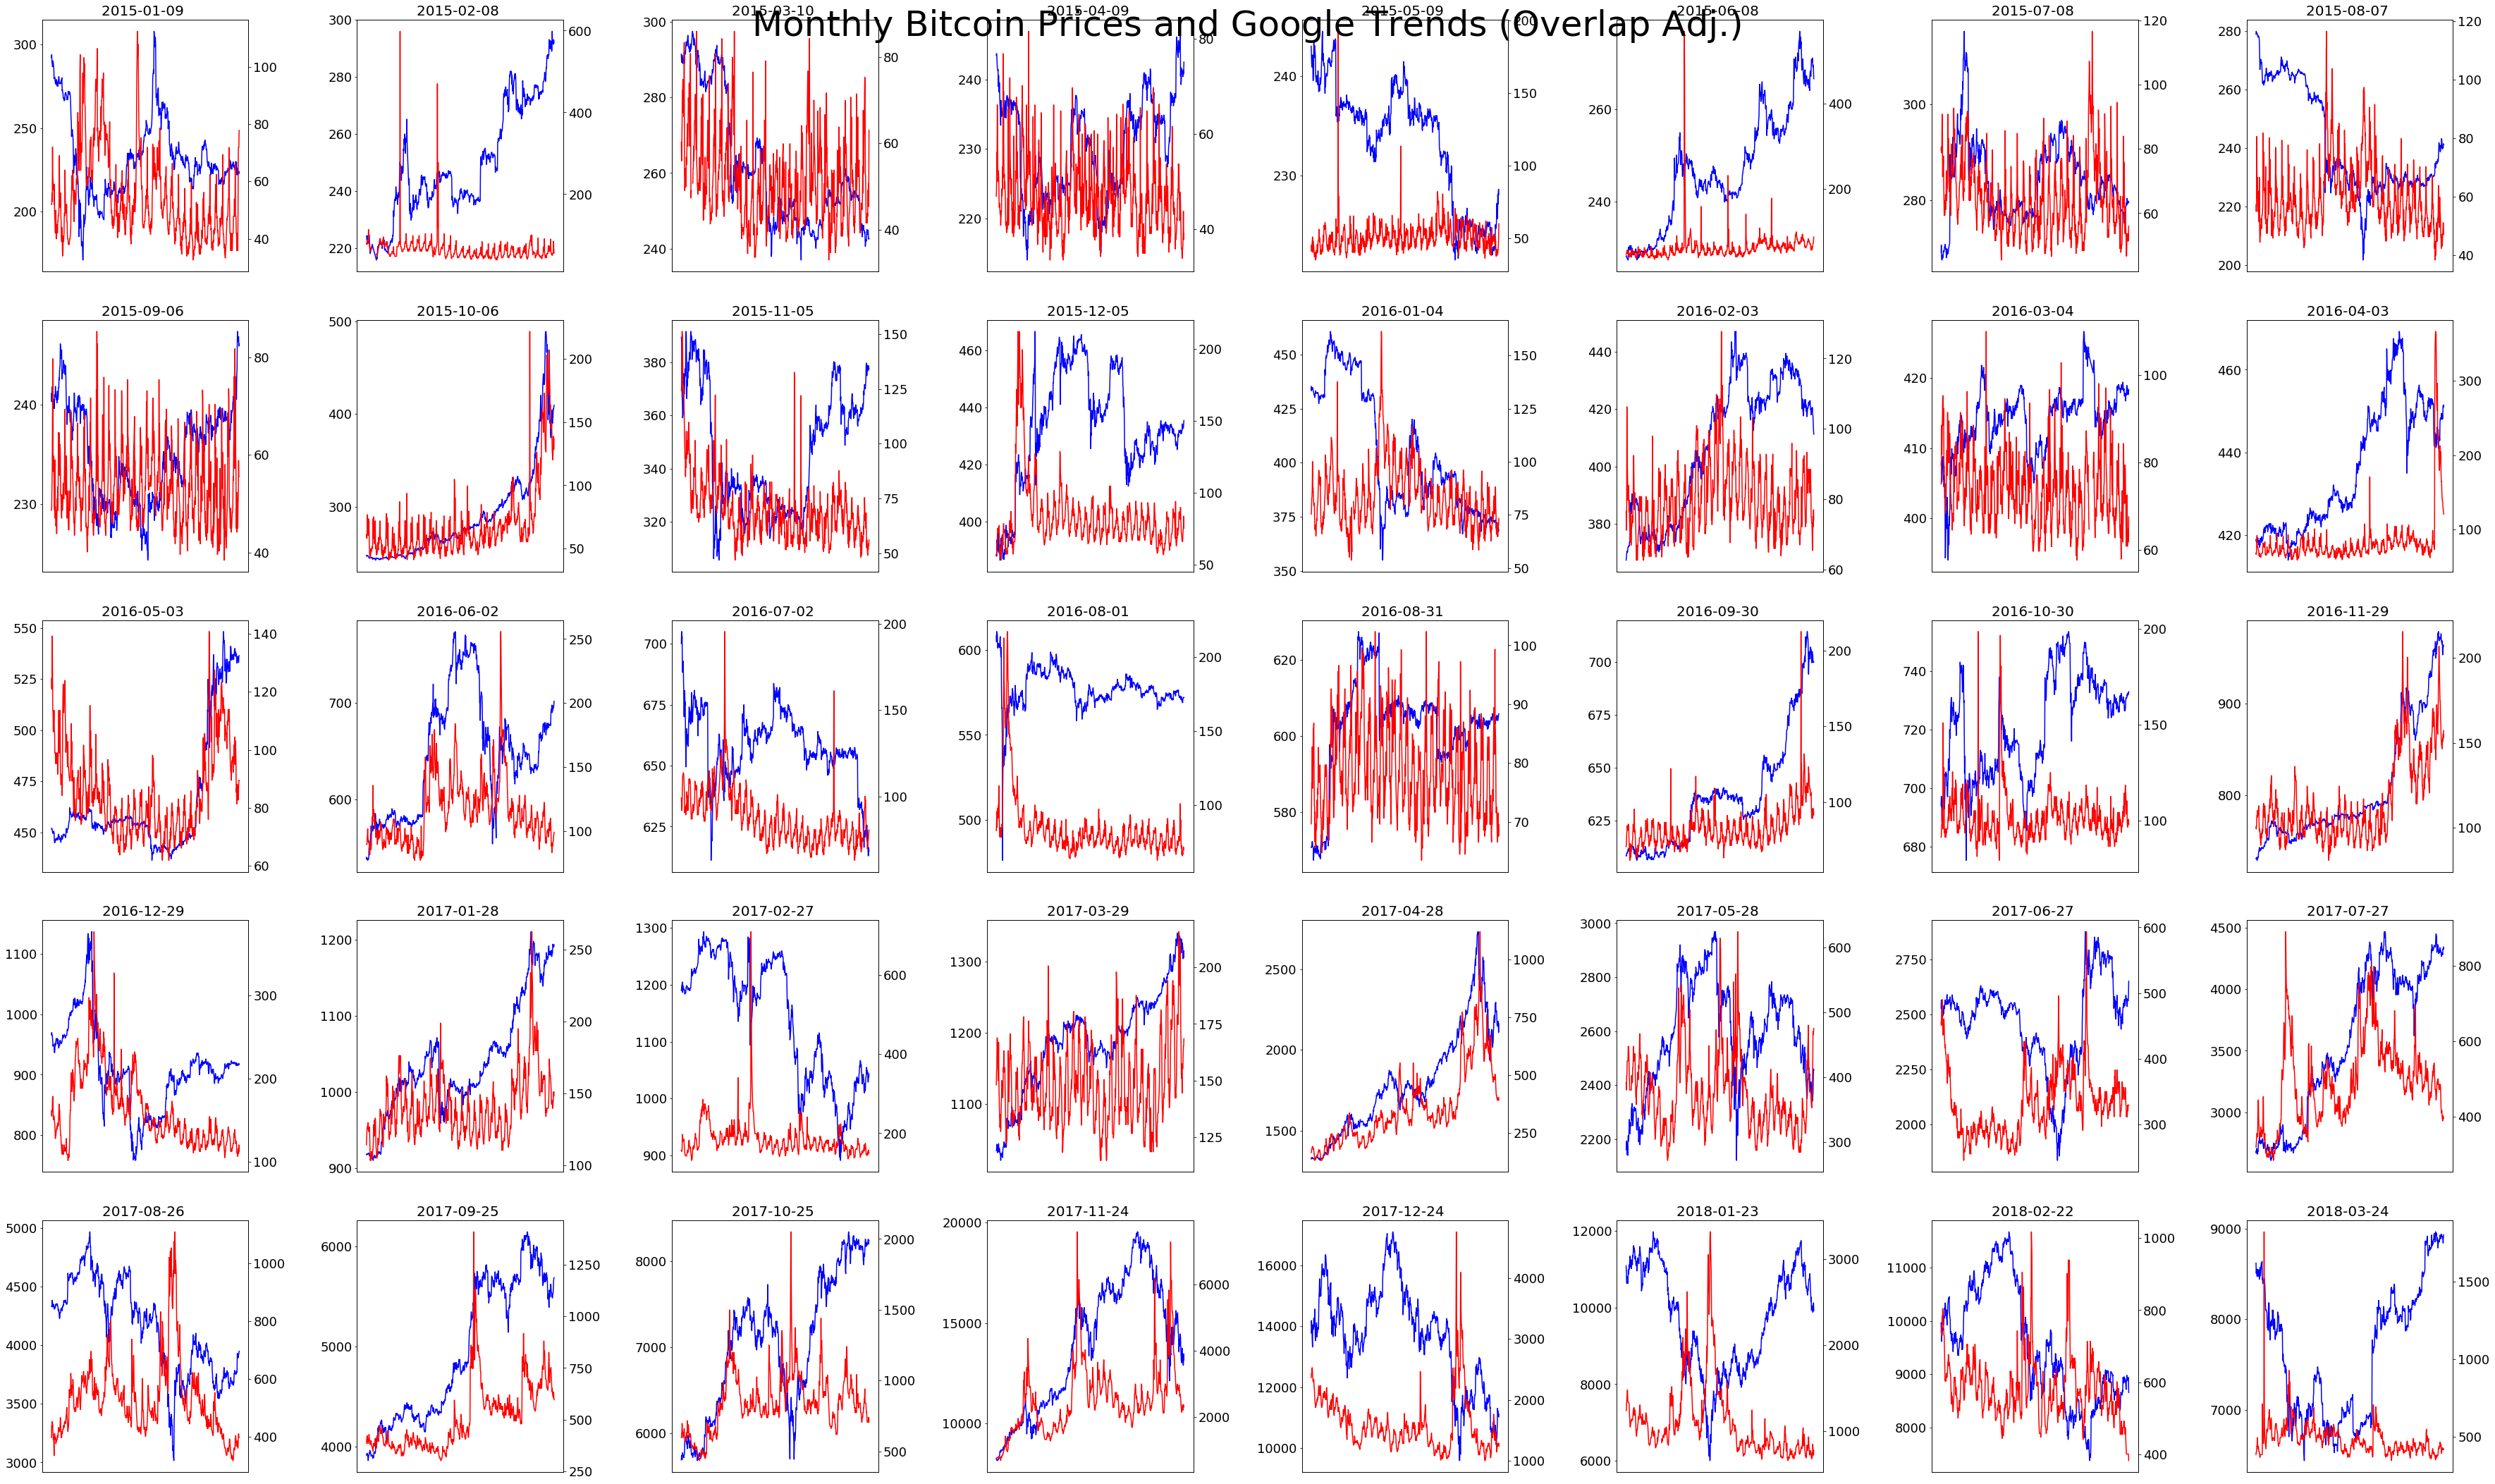

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(50,30), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly_overlap["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin (Adj.Overlap)"], color='red' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8], fontsize=20)
    start_timestamp += 2592000
    for tick in ax.get_yticklabels():
        tick.set_fontsize(18)
    for tick in ax2.get_yticklabels():
        tick.set_fontsize(18)
    ax.set_xticks([])
            
fig.suptitle("Monthly Bitcoin Prices and Google Trends (Overlap Adj.)", fontsize=50)
fig.subplots_adjust(top=0.94)
fig.tight_layout()
plt.show();

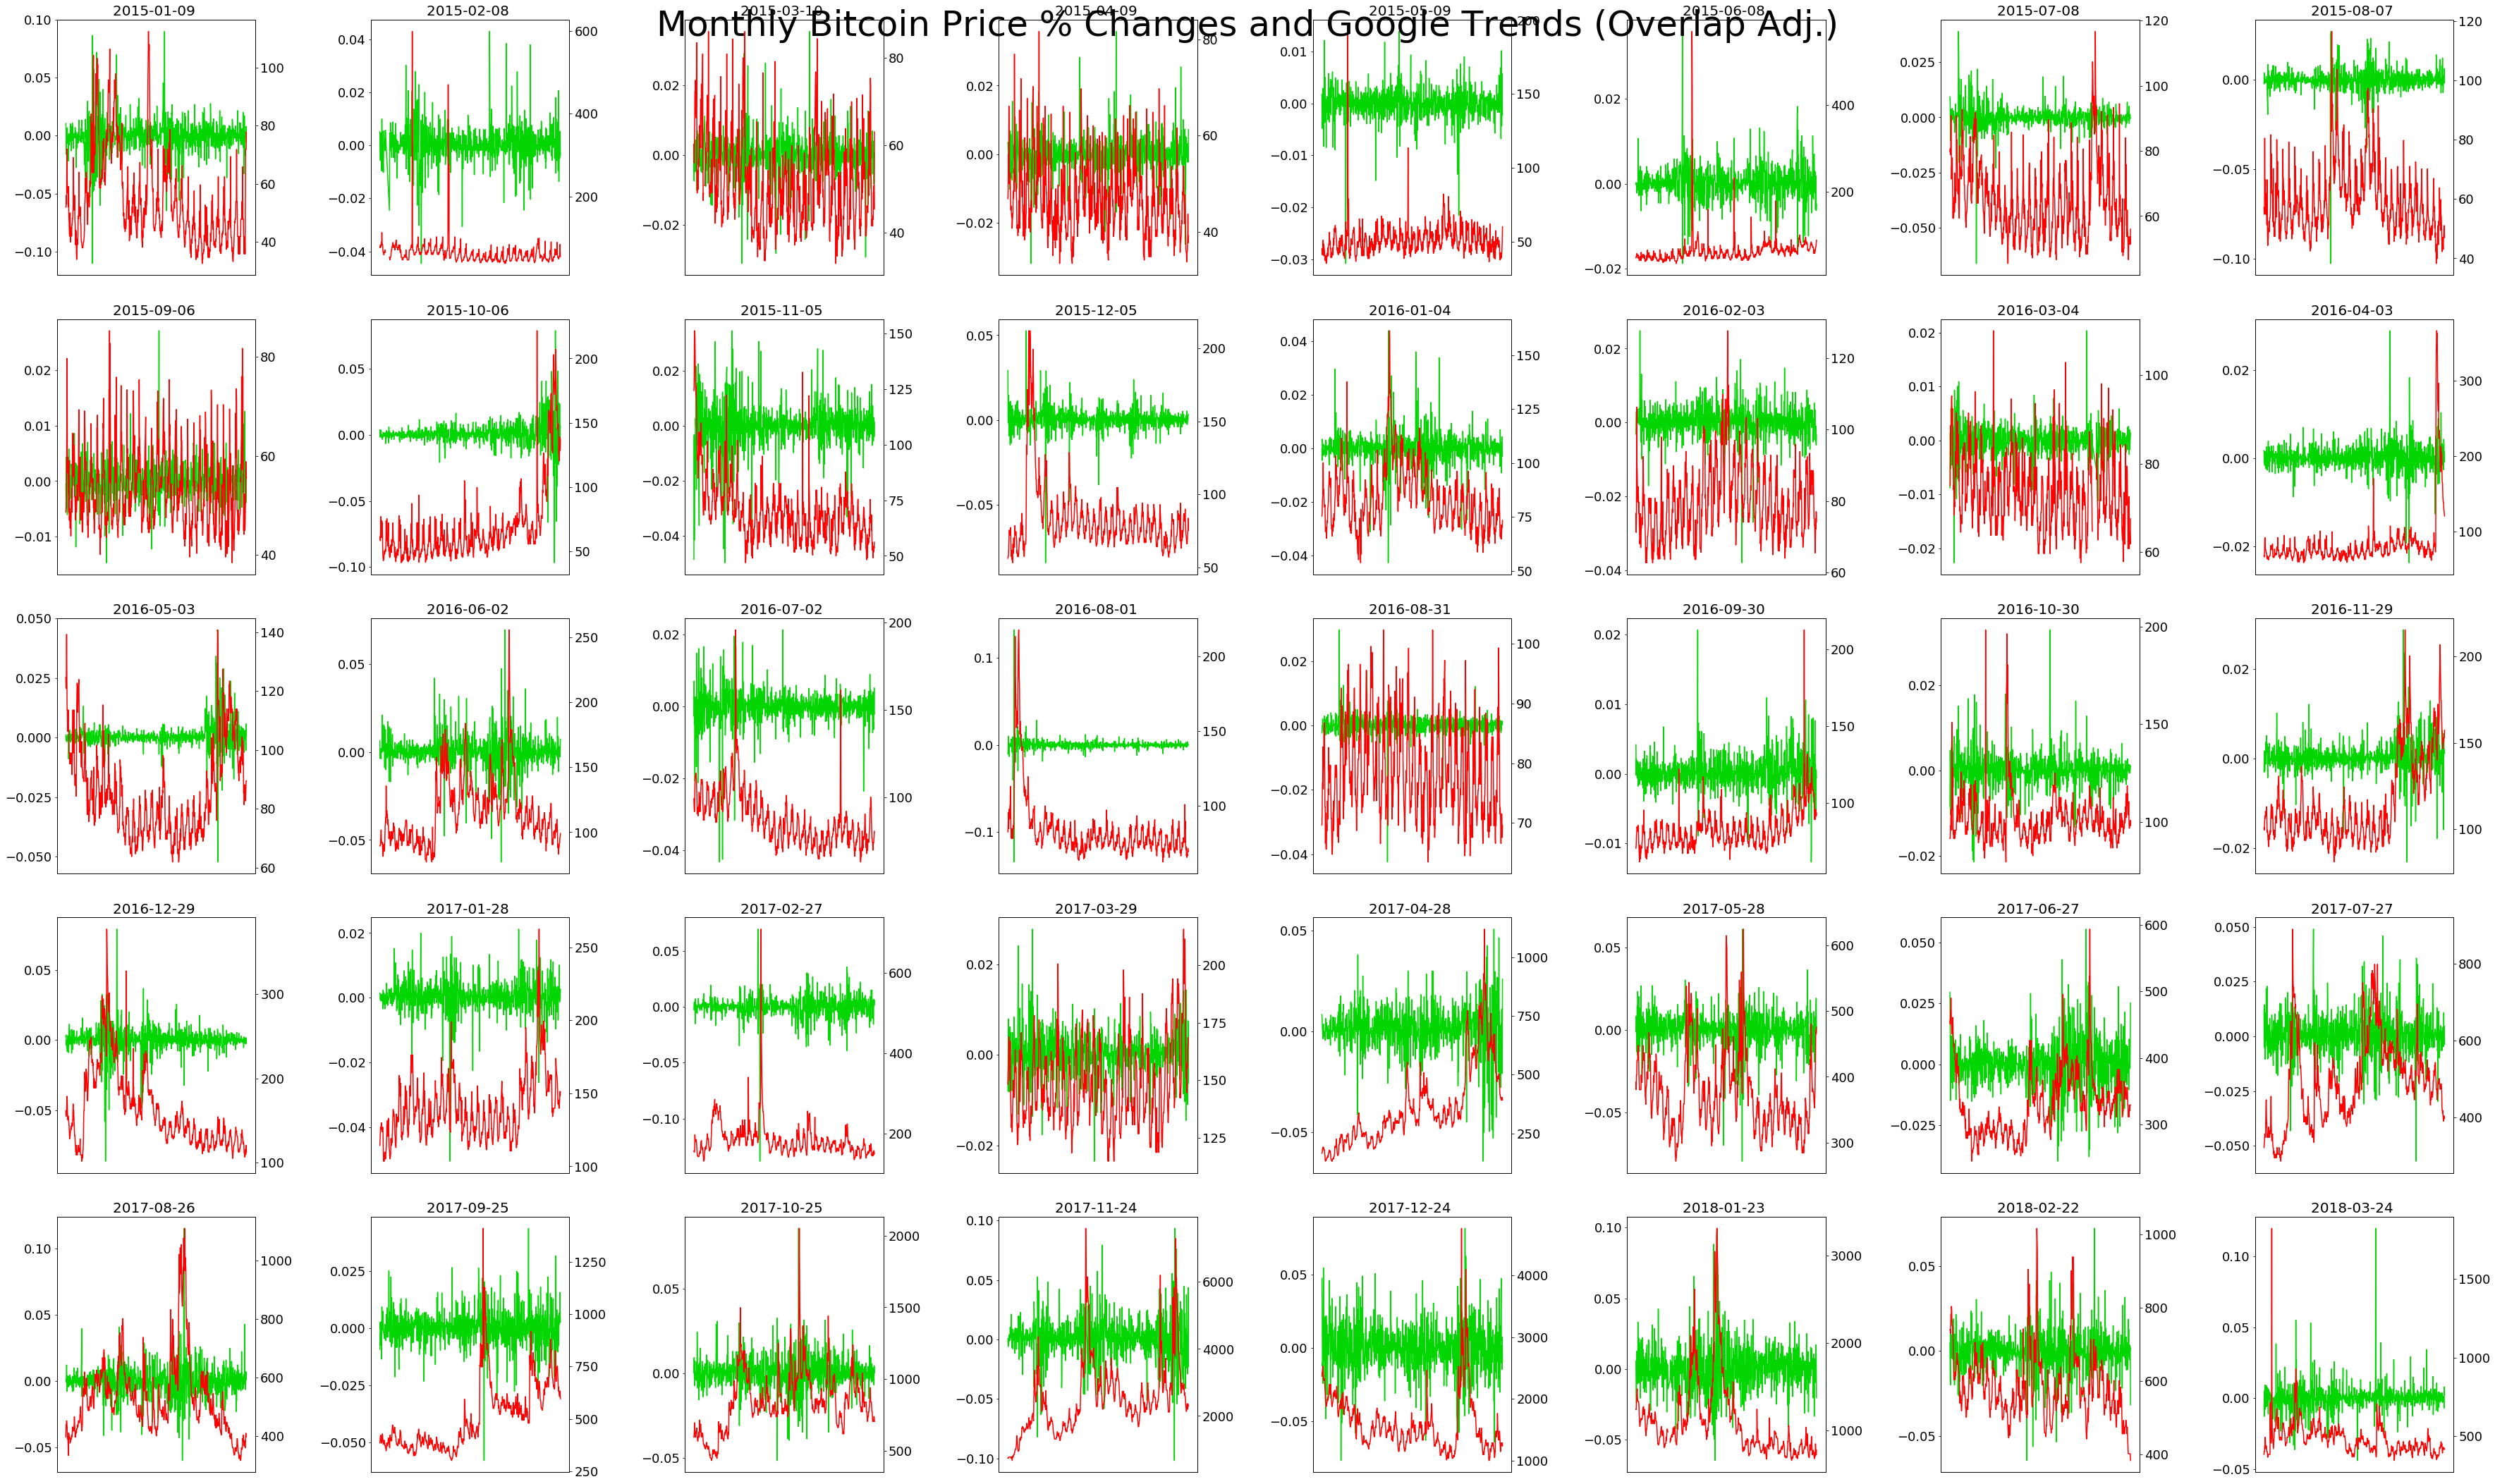

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(50,30), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly_overlap["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly_overlap["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close Price % Change"], color=light_green)
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin (Adj.Overlap)"], color='red' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8], fontsize=20)
    start_timestamp += 2592000
    for tick in ax.get_yticklabels():
        tick.set_fontsize(18)
    for tick in ax2.get_yticklabels():
        tick.set_fontsize(18)
    ax.set_xticks([])
            
fig.suptitle("Monthly Bitcoin Price % Changes and Google Trends (Overlap Adj.)", fontsize=50)
fig.subplots_adjust(top=94)
fig.tight_layout()
plt.show();

## Correlation and Anomaly Detection using Luminol

In [16]:
from luminol.anomaly_detector import AnomalyDetector 
from luminol.correlator import Correlator

# Convert dataframe into dictionary to put into luminol
timestamp_close_df = btc_and_trends_df_hourly_overlap[['Timestamp', 'Close']]
timestamp_close_percent_change_df = btc_and_trends_df_hourly_overlap[['Timestamp', 'Close Price % Change']]
timestamp_bitcoin_overlap_trend_df = btc_and_trends_df_hourly_overlap[['Timestamp', "Bitcoin (Adj.Overlap)" ]]


display(timestamp_close_df.head())
display(timestamp_close_percent_change_df.head())
display(timestamp_bitcoin_overlap_trend_df.head())

timestamp_close_dict = timestamp_close_df.set_index('Timestamp')['Close'].to_dict()
timestamp_close_percent_change_dict = timestamp_close_percent_change_df.set_index('Timestamp')['Close Price % Change'].to_dict()
timestamp_bitcoin_trend_overlap_dict = timestamp_bitcoin_overlap_trend_df.set_index('Timestamp')["Bitcoin (Adj.Overlap)"].to_dict()


Timestamp   Close
0  1420840800  289.13
1  1420844400  292.15
2  1420848000  293.89
3  1420851600  289.10
4  1420855200  288.59

Timestamp  Close Price % Change
0  1420840800                   NaN
1  1420844400              0.010445
2  1420848000              0.005956
3  1420851600             -0.016299
4  1420855200             -0.001764

Timestamp  Bitcoin (Adj.Overlap)
0  1420840800                   53.0
1  1420844400                   52.0
2  1420848000                   52.0
3  1420851600                   56.0
4  1420855200                   53.0

In [17]:
def anomaly_research(input_data_dict, master_df, target_column_name, y2_col_name, new_col_name, color1='blue', color2='red', algorithm_name=None, algorithm_params=None ):
    
    anomaly_detector = AnomalyDetector(input_data_dict)
    scores = anomaly_detector.get_all_scores()

    master_df[new_col_name] = 0
    
    anomaly_df = pd.DataFrame(columns=['Timestamp', 'Date', target_column_name])

    for timestamp, value in scores.iteritems():
        readable_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H')
        anomaly_df = anomaly_df.append({'Timestamp':timestamp, 'Date': readable_date, 'Anomaly Score': value}, ignore_index=True)

    anomalies = anomaly_detector.get_anomalies()
    
    display('There were '+ str(len(anomalies))+ ' anomalies in the Timeseries data for ' + target_column_name)
    
    if (len(anomalies) == 0):
        return master_df
    
    for anomaly in anomalies:
        time_period = anomaly.get_time_window()

        start, end = time_period
        is_in_period = (master_df["Timestamp"] > start) & (master_df["Timestamp"] < end)
        master_df.loc[is_in_period, new_col_name] = 1 

    display('There are ' + str(len(master_df[master_df[new_col_name] == 1])) + ' rows with anomalies' )
    
    fig, axes = plt.subplots(nrows=len(anomalies), ncols=1, figsize=(40,40), sharex=False, sharey=False)

    for i, ax in enumerate(axes.flatten()):    
        time_period = anomalies[i].get_time_window()
        start_timestamp = time_period[0]
        end_timestamp = time_period[1] 

        in_range_df = master_df[ (master_df["Timestamp"] > start_timestamp) & (master_df["Timestamp"] <= end_timestamp) ]

        ax.plot(in_range_df["Date(UTC)"], in_range_df[target_column_name], color=color1)

        ax2 = ax.twinx()
        ax2.plot(in_range_df['Date(UTC)'], in_range_df[y2_col_name], color=color2)

        ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(in_range_df["Date(UTC)"].iloc[-1])[:-8], fontsize=20 )
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
            tick.set_fontsize(20)

        axes_list = [ax,ax2]
        for ax in axes_list:
            for tick in ax.get_yticklabels():
                tick.set_fontsize(20)

    fig.suptitle("Anomalies in " + target_column_name,  fontsize=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show();
    
    has_anomaly = master_df[master_df[new_col_name] == 1]
    no_anomaly = master_df[master_df[new_col_name] == 0]

    fig, ax = plt.subplots(figsize=(40,20))
    l1, = ax.plot(has_anomaly["Date(UTC)"], has_anomaly[target_column_name],color='black', linestyle="None", marker='o')
    l2, = ax.plot(no_anomaly["Date(UTC)"], no_anomaly[target_column_name], color="red")
    if algorithm_name is None:
        ax.set_title(target_column_name + ' Anomalies (Bitmap Detector)', fontsize=40)
    else: 
        ax.set_title(target_column_name + ' Anomalies (' + algorithm_name + ')', fontsize=40)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(30)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(30)
    plt.legend([l1, l2],[target_column_name + ' (Anomaly)', target_column_name], fontsize=40)
    plt.show() 
    
    return master_df


'There were 9 anomalies in the Timeseries data for Close'

'There are 1492 rows with anomalies'

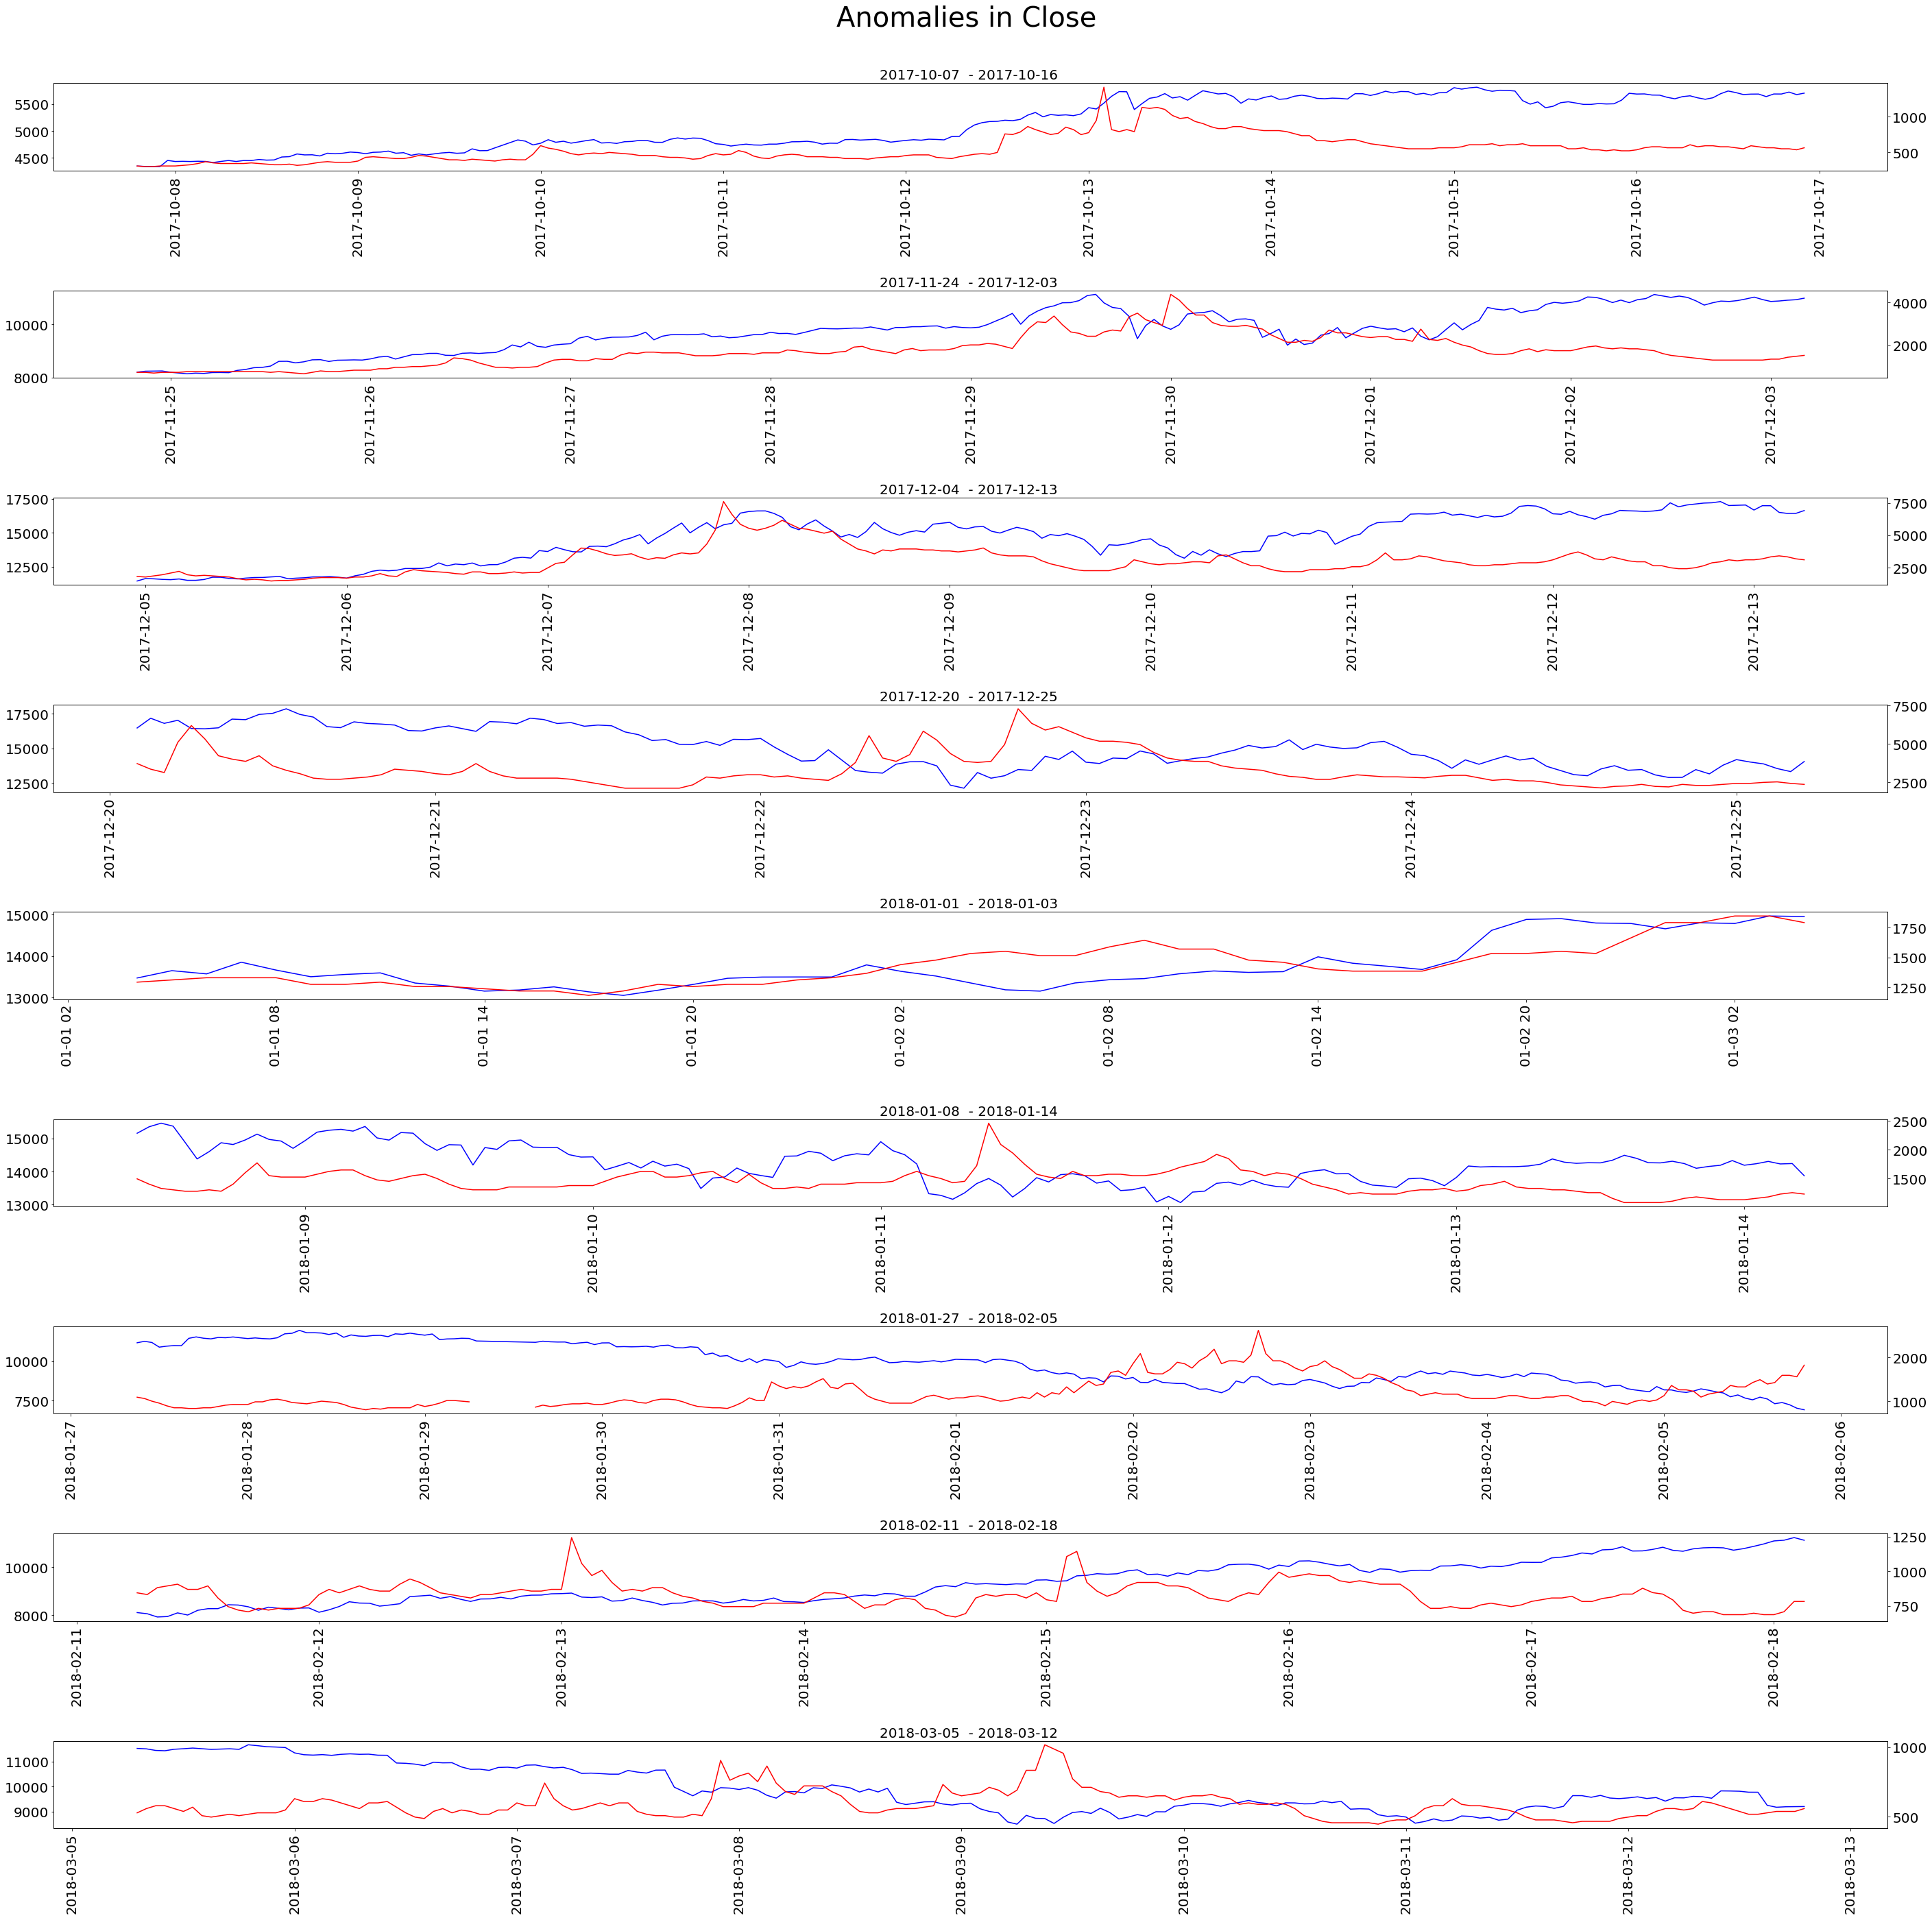

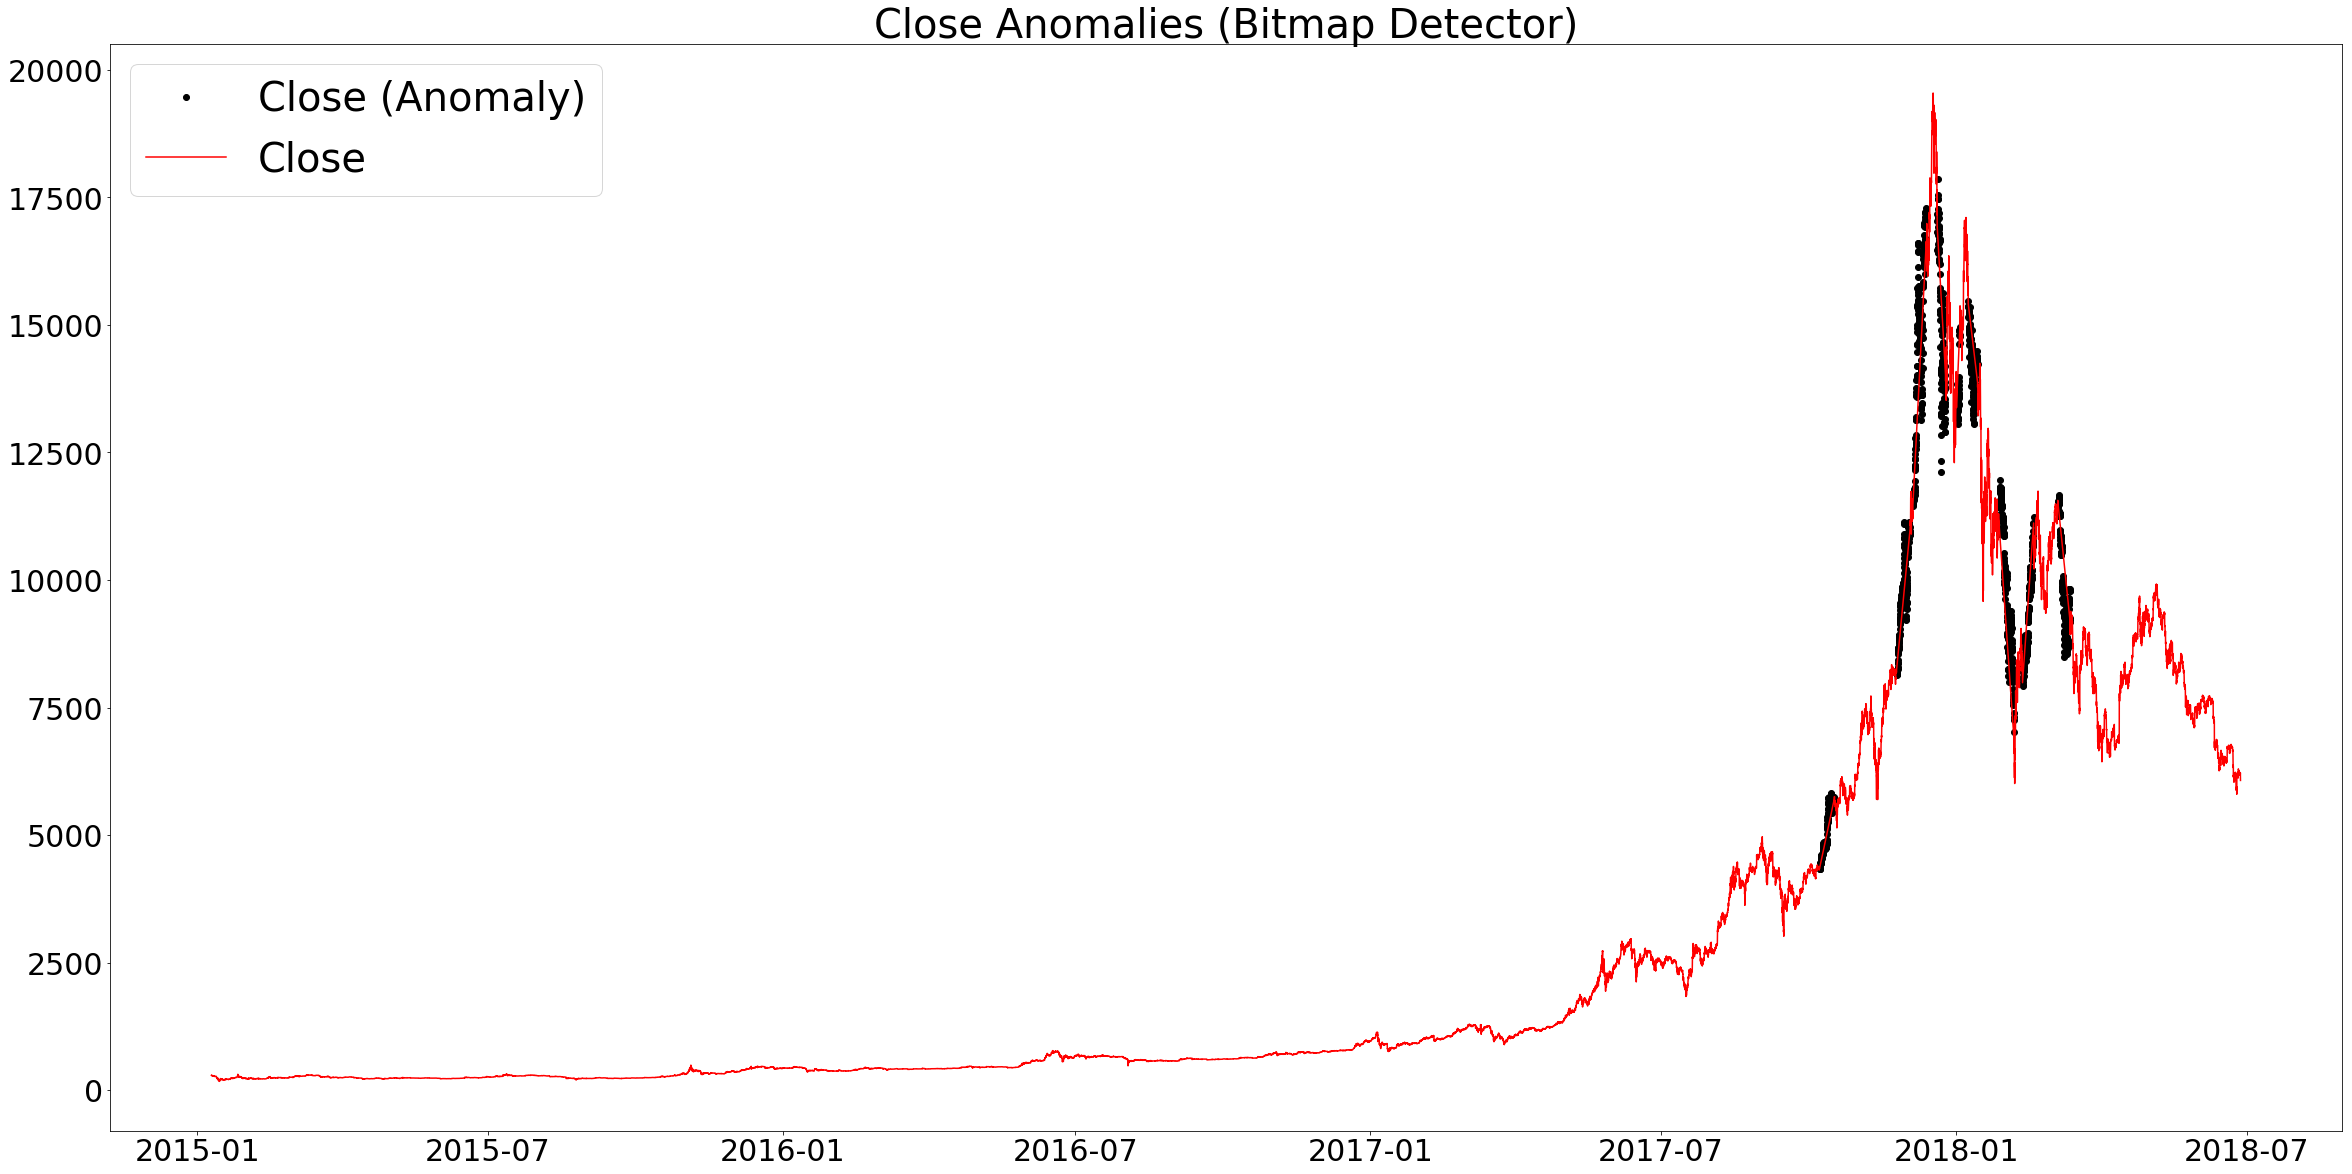

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   
2  1420848000  293.89  293.89  293.89  293.89      0.158015   
3  1420851600  289.20  289.20  289.10  289.10     30.985828   
4  1420855200  289.18  289.18  288.57  288.59      7.694195   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 17:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   
2          46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 19:00:00   
3        8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 20:00:00   
4        2224.105007      289.062740 2015-01-10 02:00:00 2015-01-09 21:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   53.0      False 2015-01-09 22:00:00+00:00   
1                   52.0      False 2015-01-09 23:00:00+00:00   
2                   52.0      False 2015-01-10 00:00:00+00:00   
3                   56.0      False 2015-01-10 01:00:00+00:00   
4                   53.0      False 2015-01-10 02:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
0                53                   NaN                         NaN   
1                52              0.010445                    0.010445   
2                52              0.005956                    0.005956   
3                56             -0.016299                    0.016299   
4                53             -0.001764                    0.001764   

   Is Price Anomaly (Bitmap Detector)  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0

In [18]:
#input_data_dict, master_df, target_column_name, y2_col_name, new_col_name, color1='blue', 
# color2='red', algorithm_name=None, algorithm_params=None 
btc_and_trends_df_hourly_overlap = anomaly_research(timestamp_close_dict, btc_and_trends_df_hourly_overlap, "Close", "Bitcoin (Adj.Overlap)", "Is Price Anomaly (Bitmap Detector)")

display(btc_and_trends_df_hourly_overlap.head())

'There were 9 anomalies in the Timeseries data for Close'

'There are 1492 rows with anomalies'

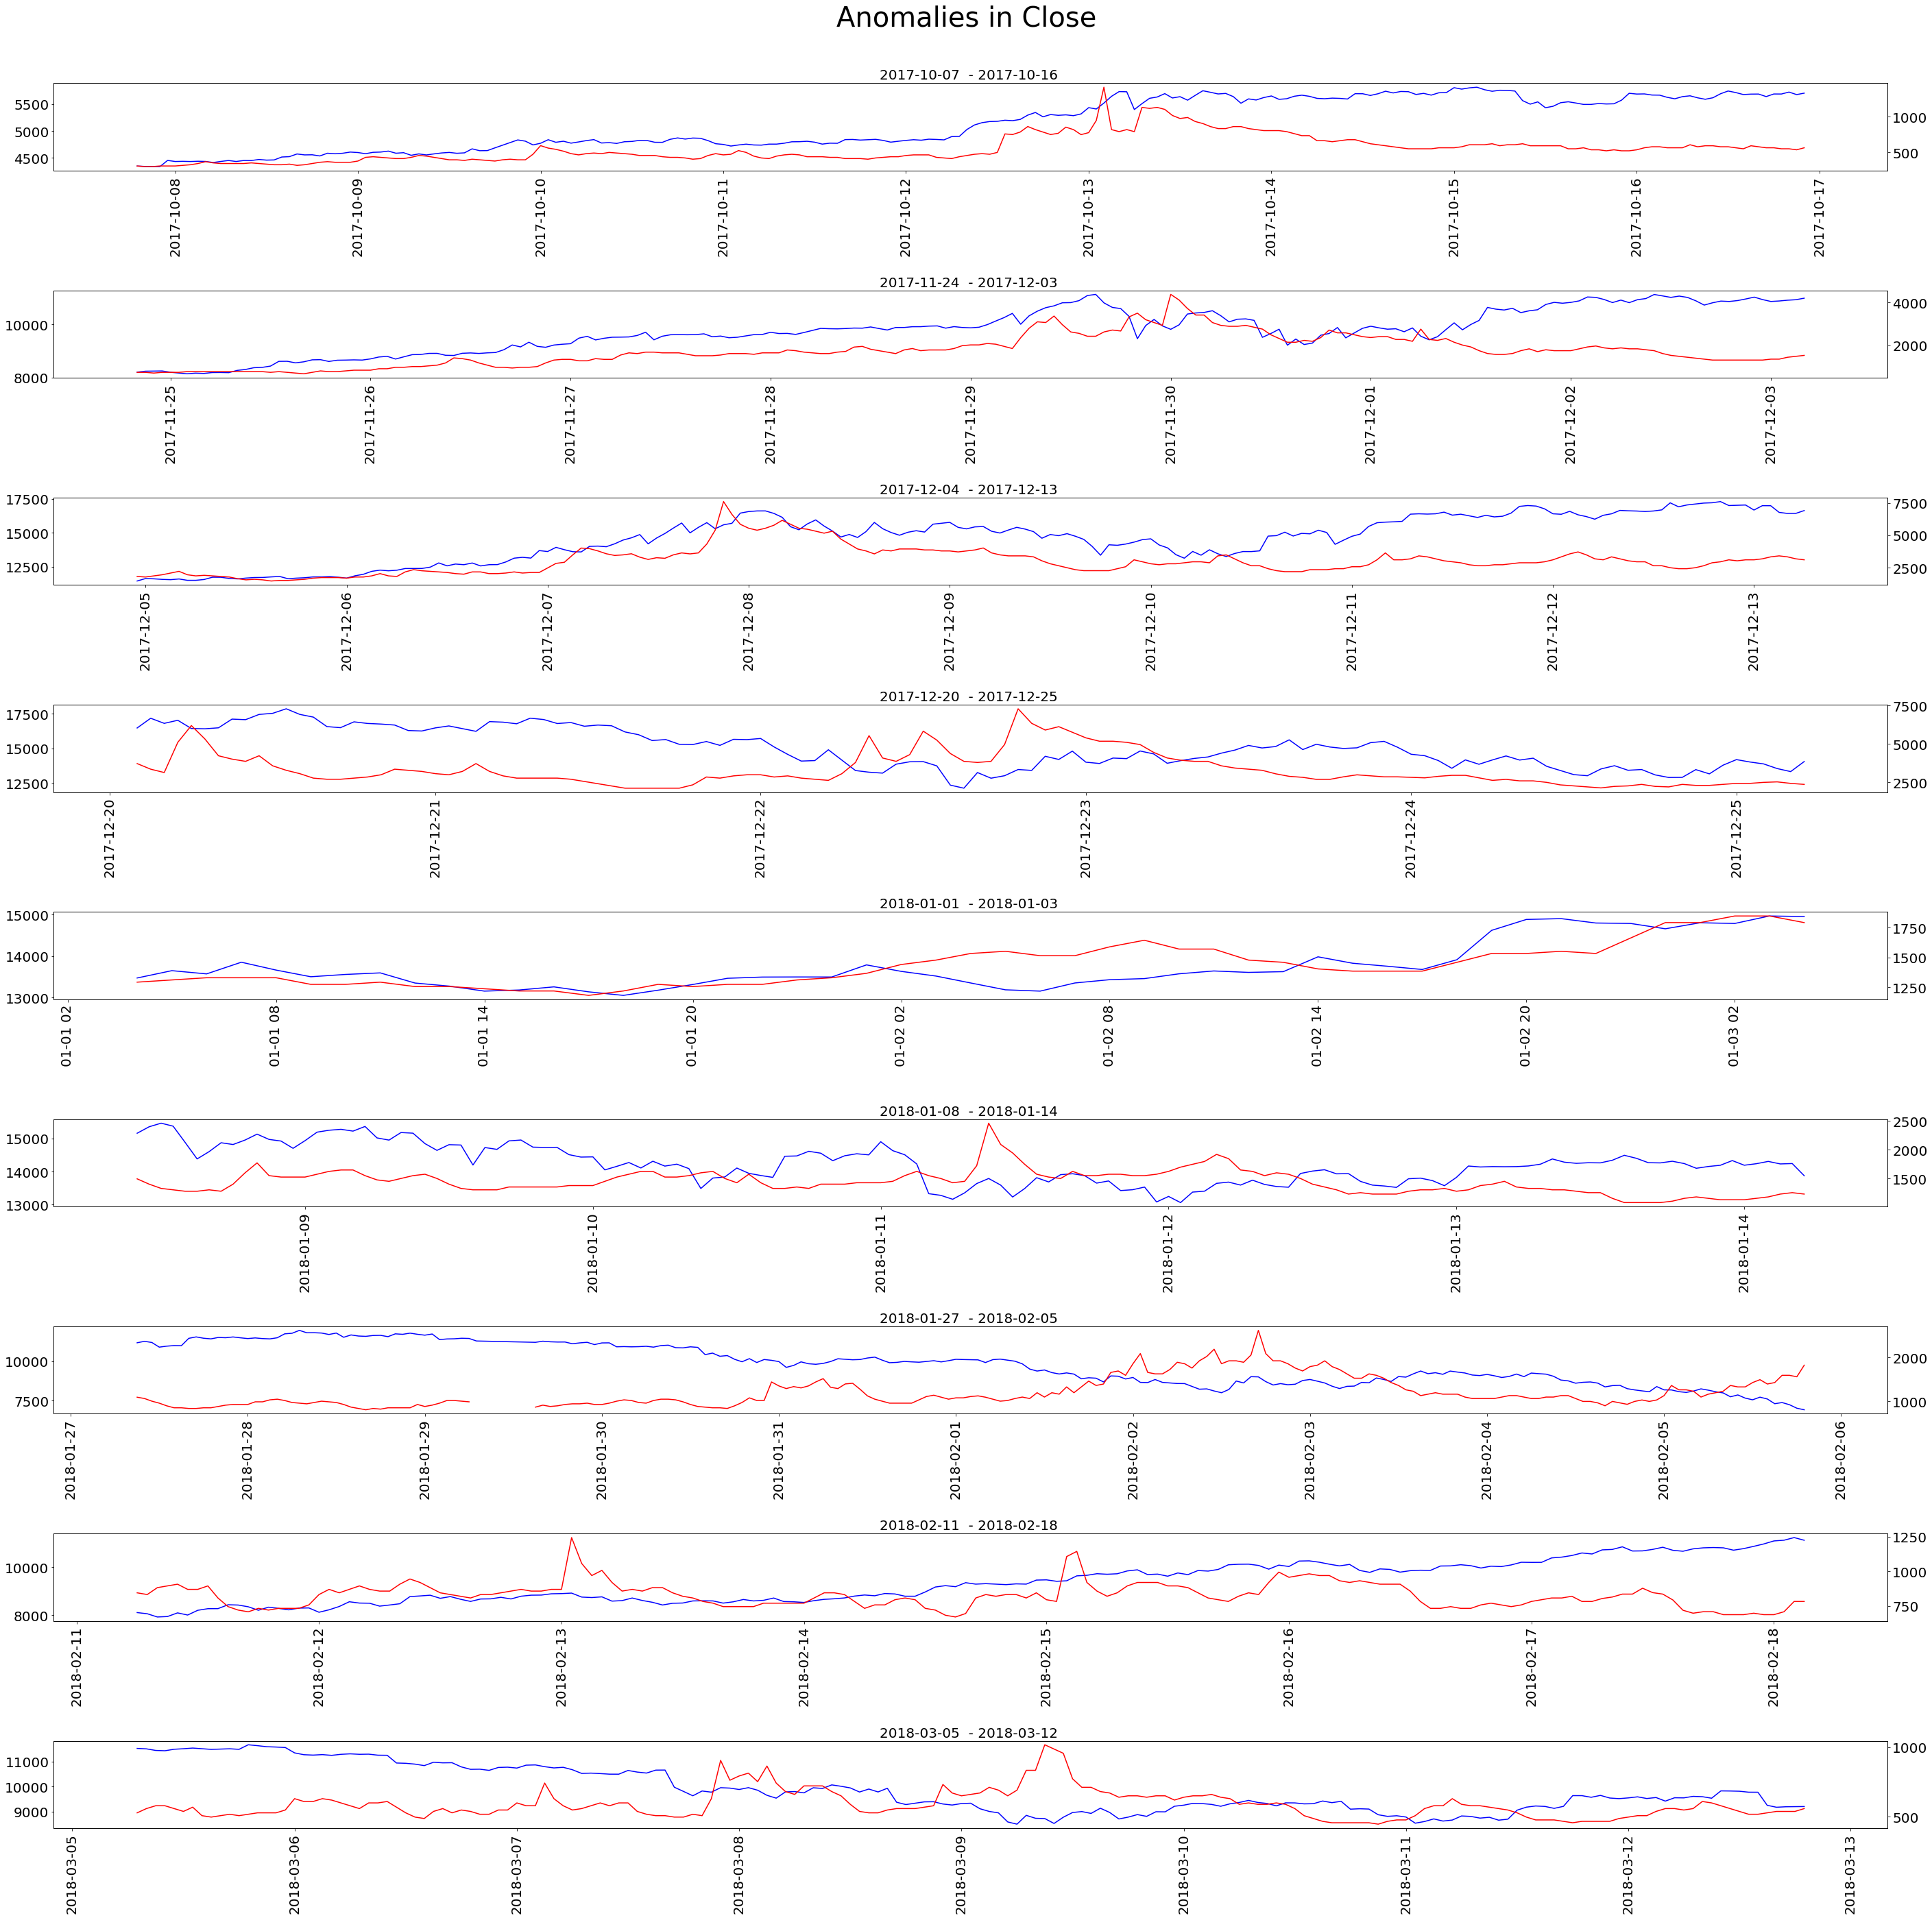

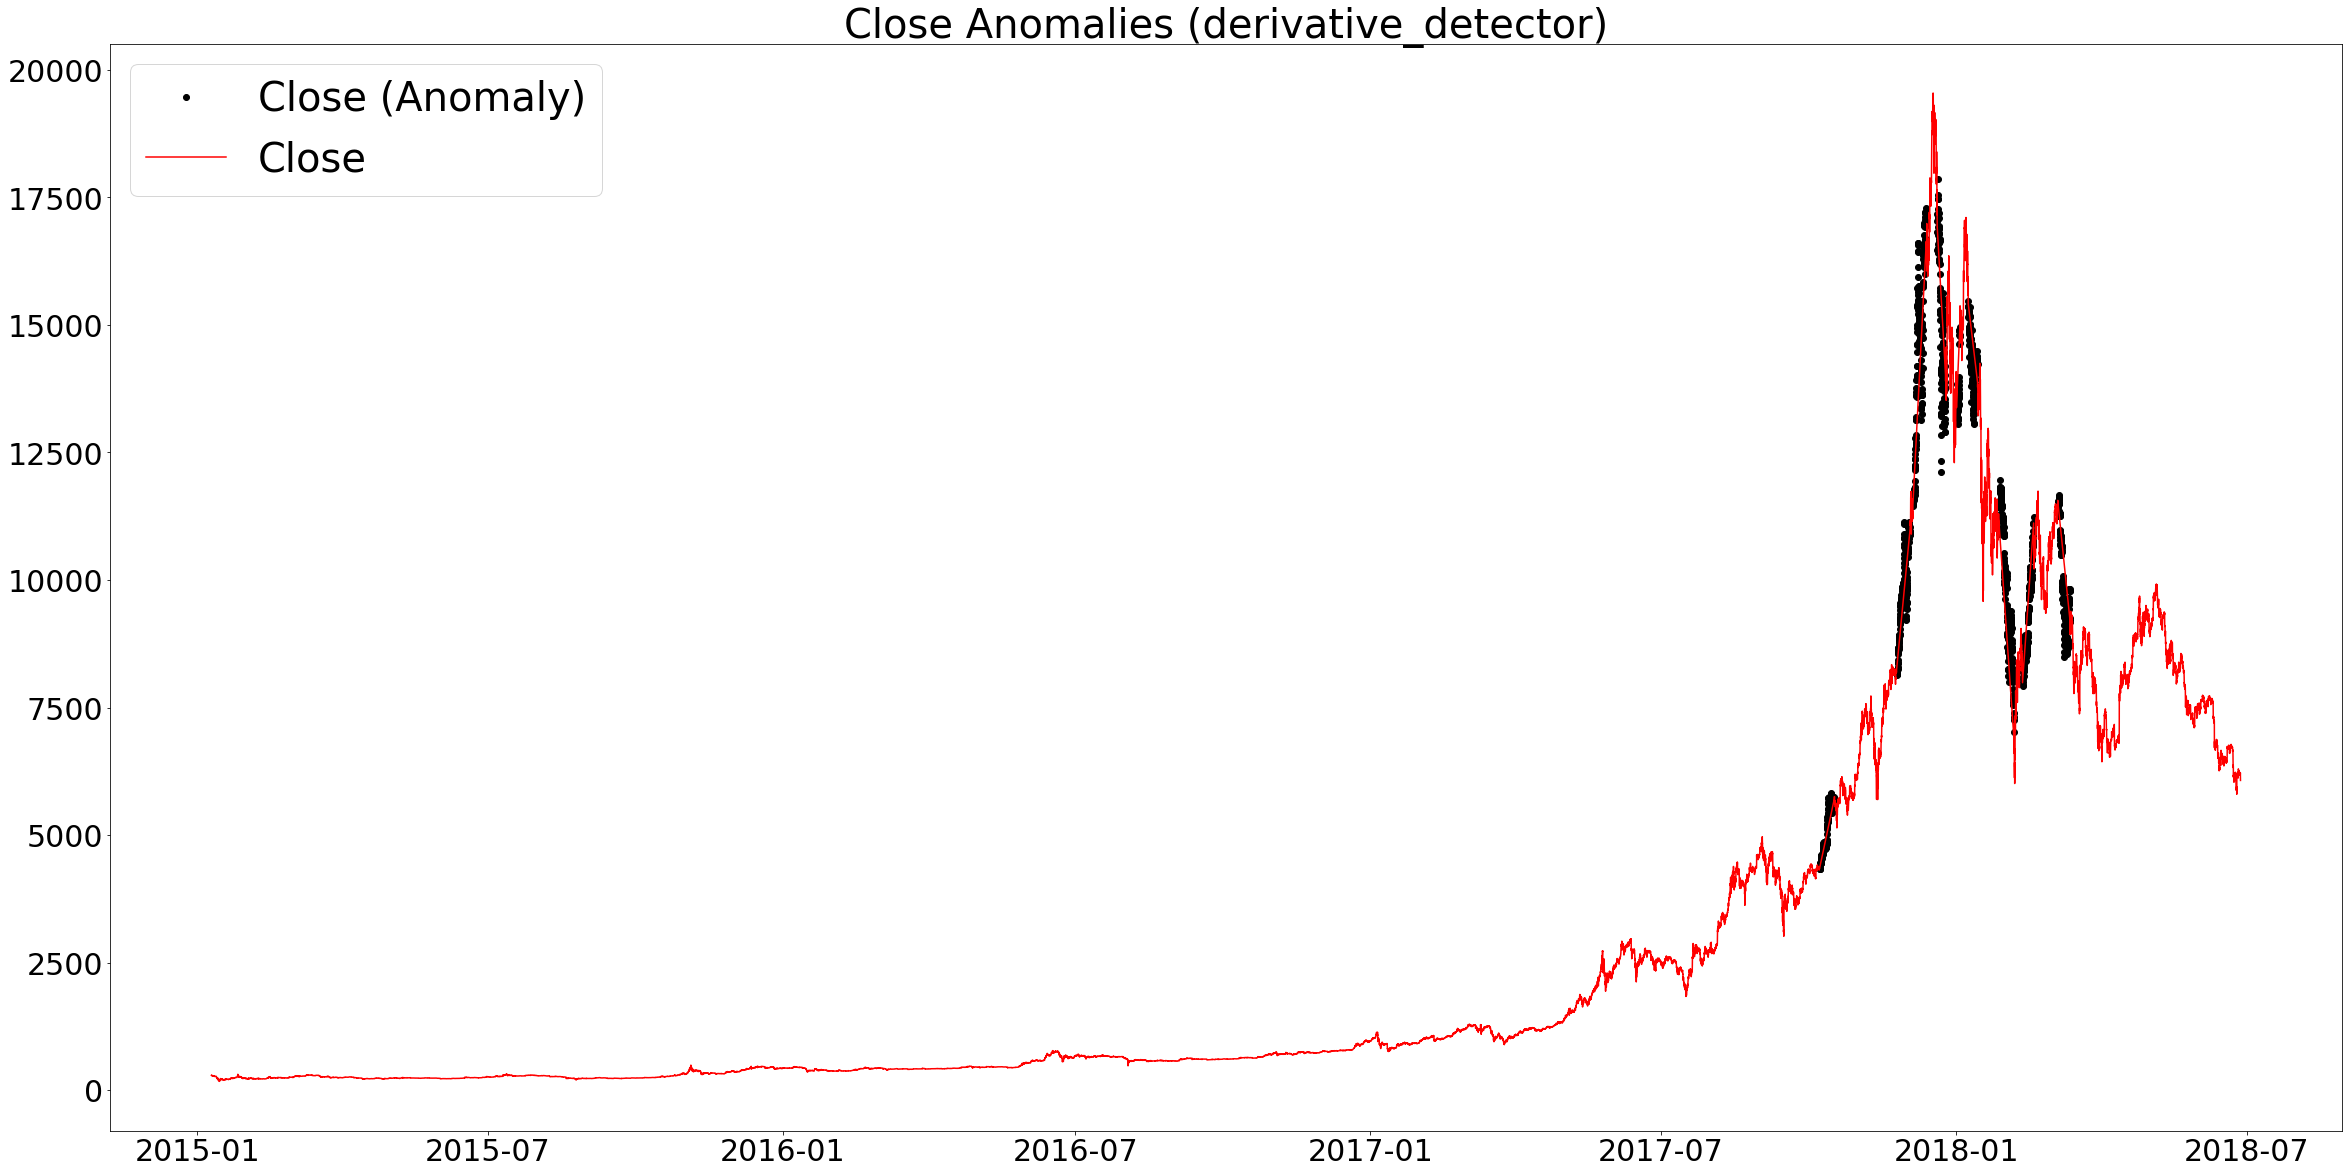

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   
2  1420848000  293.89  293.89  293.89  293.89      0.158015   
3  1420851600  289.20  289.20  289.10  289.10     30.985828   
4  1420855200  289.18  289.18  288.57  288.59      7.694195   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 17:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   
2          46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 19:00:00   
3        8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 20:00:00   
4        2224.105007      289.062740 2015-01-10 02:00:00 2015-01-09 21:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   53.0      False 2015-01-09 22:00:00+00:00   
1                   52.0      False 2015-01-09 23:00:00+00:00   
2                   52.0      False 2015-01-10 00:00:00+00:00   
3                   56.0      False 2015-01-10 01:00:00+00:00   
4                   53.0      False 2015-01-10 02:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
0                53                   NaN                         NaN   
1                52              0.010445                    0.010445   
2                52              0.005956                    0.005956   
3                56             -0.016299                    0.016299   
4                53             -0.001764                    0.001764   

   Is Price Anomaly (Bitmap Detector)  Is Price Anomaly (Derivative Detector)  
0                                   0                                       0  
1                                   0                                       0  
2                                   0                                       0  
3                                   0                                       0  
4                                   0                                       0

In [19]:
btc_and_trends_df_hourly_overlap = anomaly_research(timestamp_close_dict, btc_and_trends_df_hourly_overlap, "Close", "Bitcoin (Adj.Overlap)", "Is Price Anomaly (Derivative Detector)", algorithm_name='derivative_detector')
display(btc_and_trends_df_hourly_overlap.head())

TODO: get anomalies for the % Change, then plot the anomalies for these against the normal Price Graph

Note: Bitmap and Derivative detector somehow both mark the same points as anomalies 

Note: Might need to explore other "anomaly detection" options, such as just simply calculating percent differences and deciding on a threshold to decide if something is anomaly or not 

In [20]:
btc_and_trends_df_hourly_overlap = anomaly_research(timestamp_close_percent_change_dict, btc_and_trends_df_hourly_overlap, "Close Price % Change", "Bitcoin (Adj.Overlap)", "Is Price % Change Anomaly (Bitmap Detector)")
display(btc_and_trends_df_hourly_overlap.head())

'There were 0 anomalies in the Timeseries data for Close Price % Change'

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   
2  1420848000  293.89  293.89  293.89  293.89      0.158015   
3  1420851600  289.20  289.20  289.10  289.10     30.985828   
4  1420855200  289.18  289.18  288.57  288.59      7.694195   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 17:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   
2          46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 19:00:00   
3        8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 20:00:00   
4        2224.105007      289.062740 2015-01-10 02:00:00 2015-01-09 21:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   53.0      False 2015-01-09 22:00:00+00:00   
1                   52.0      False 2015-01-09 23:00:00+00:00   
2                   52.0      False 2015-01-10 00:00:00+00:00   
3                   56.0      False 2015-01-10 01:00:00+00:00   
4                   53.0      False 2015-01-10 02:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
0                53                   NaN                         NaN   
1                52              0.010445                    0.010445   
2                52              0.005956                    0.005956   
3                56             -0.016299                    0.016299   
4                53             -0.001764                    0.001764   

   Is Price Anomaly (Bitmap Detector)  Is Price Anomaly (Derivative Detector)  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   

   Is Price % Change Anomaly (Bitmap Detector)  
0                                            0  
1                                            0  
2                                            0  
3                                            0  
4                                            0

In [21]:

btc_and_trends_df_hourly_overlap = anomaly_research(timestamp_bitcoin_trend_overlap_dict, btc_and_trends_df_hourly_overlap, "Bitcoin (Adj.Overlap)", "Close", "Is Trend Anomaly (Bitmap Detector)")
display(btc_and_trends_df_hourly_overlap.head())

'There were 0 anomalies in the Timeseries data for Bitcoin (Adj.Overlap)'

Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   
2  1420848000  293.89  293.89  293.89  293.89      0.158015   
3  1420851600  289.20  289.20  289.10  289.10     30.985828   
4  1420855200  289.18  289.18  288.57  288.59      7.694195   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 17:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   
2          46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 19:00:00   
3        8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 20:00:00   
4        2224.105007      289.062740 2015-01-10 02:00:00 2015-01-09 21:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   53.0      False 2015-01-09 22:00:00+00:00   
1                   52.0      False 2015-01-09 23:00:00+00:00   
2                   52.0      False 2015-01-10 00:00:00+00:00   
3                   56.0      False 2015-01-10 01:00:00+00:00   
4                   53.0      False 2015-01-10 02:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
0                53                   NaN                         NaN   
1                52              0.010445                    0.010445   
2                52              0.005956                    0.005956   
3                56             -0.016299                    0.016299   
4                53             -0.001764                    0.001764   

   Is Price Anomaly (Bitmap Detector)  Is Price Anomaly (Derivative Detector)  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   

   Is Price % Change Anomaly (Bitmap Detector)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Is Trend Anomaly (Bitmap Detector)  
0                                   0  
1                                   0  
2                                   0  
3                                   0  
4                                   0

With a Percentile threshold of 0.900000, the cutoff value is 0.007141


Timestamp    Open    High     Low   Close  Volume_(BTC)  \
5   1420858800  286.66  286.98  286.65  286.70    501.942237   
11  1420880400  280.00  280.00  279.11  279.55     12.271850   
12  1420884000  280.11  280.58  279.60  279.60     14.809935   
43  1420995600  272.97  272.97  272.97  272.97      0.039084   
44  1420999200  271.10  271.10  271.10  271.10      5.713943   

    Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
5       143886.762160      286.660001 2015-01-10 03:00:00 2015-01-09 22:00:00   
11        3429.780674      279.483598 2015-01-10 09:00:00 2015-01-10 04:00:00   
12        4141.657688      279.654017 2015-01-10 10:00:00 2015-01-10 05:00:00   
43          10.668702      272.970000 2015-01-11 17:00:00 2015-01-11 12:00:00   
44        1549.049958      271.100000 2015-01-11 18:00:00 2015-01-11 13:00:00   

    Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
5                    72.0      False 2015-01-10 03:00:00+00:00   
11                   52.0      False 2015-01-10 09:00:00+00:00   
12                   59.0      False 2015-01-10 10:00:00+00:00   
43                   36.0      False 2015-01-11 17:00:00+00:00   
44                   34.0      False 2015-01-11 18:00:00+00:00   

    Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
5                 72             -0.006549                    0.006549   
11                52             -0.021868                    0.021868   
12                59              0.000179                    0.000179   
43                36              0.002093                    0.002093   
44                34             -0.006851                    0.006851   

    Moving Average Price  Moving Average Price % Change  \
5             288.130000                      -0.008249   
11            284.016667                      -0.010533   
12            281.650000                      -0.008333   
43            275.166667                      -0.007443   
44            272.156667                      -0.010939   

    MA % Change (Abs.Value)  
5                  0.008249  
11                 0.010533  
12                 0.008333  
43                 0.007443  
44                 0.010939

There are 3030 rows above threshold


Timestamp     Open     High      Low    Close  Volume_(BTC)  \
30292  1530043200  6167.38  6180.49  6167.37  6180.49     15.022391   
30293  1530046800  6189.81  6190.80  6182.00  6189.15      0.139018   
30294  1530050400  6220.36  6224.13  6218.41  6220.67      1.275520   
30295  1530054000  6160.78  6160.78  6154.60  6156.28     10.957354   
30296  1530057600  6073.99  6075.41  6064.56  6070.79     23.511004   

       Volume_(Currency)  Weighted_Price           Date(UTC)  \
30292       92783.884390     6176.372747 2018-06-26 20:00:00   
30293         859.799966     6184.792561 2018-06-26 21:00:00   
30294        7933.435903     6219.767345 2018-06-26 22:00:00   
30295       67442.625138     6155.010318 2018-06-26 23:00:00   
30296      142706.803850     6069.787707 2018-06-27 00:00:00   

                     date  Bitcoin (Adj.Overlap)  isPartial  \
30292 2018-06-26 15:00:00             285.669542      False   
30293 2018-06-26 16:00:00             290.064458      False   
30294 2018-06-26 17:00:00             290.064458      False   
30295 2018-06-26 18:00:00             268.089878      False   
30296 2018-06-26 19:00:00             259.300046      False   

                 Date_UTC_trend  Bitcoin (Unadj.)  Close Price % Change  \
30292 2018-06-26 20:00:00+00:00                65              0.000468   
30293 2018-06-26 21:00:00+00:00                66              0.001401   
30294 2018-06-26 22:00:00+00:00                66              0.005093   
30295 2018-06-26 23:00:00+00:00                61             -0.010351   
30296 2018-06-27 00:00:00+00:00                59             -0.013887   

       Close Price % Change (Abs)  Moving Average Price  \
30292                    0.000468           6181.630000   
30293                    0.001401           6182.413333   
30294                    0.005093           6196.770000   
30295                    0.010351           6188.700000   
30296                    0.013887           6149.246667   

       Moving Average Price % Change  MA % Change (Abs.Value)  
30292                       0.000109                 0.000109  
30293                       0.000127                 0.000127  
30294                       0.002322                 0.002322  
30295                      -0.001302                 0.001302  
30296                      -0.006375                 0.006375

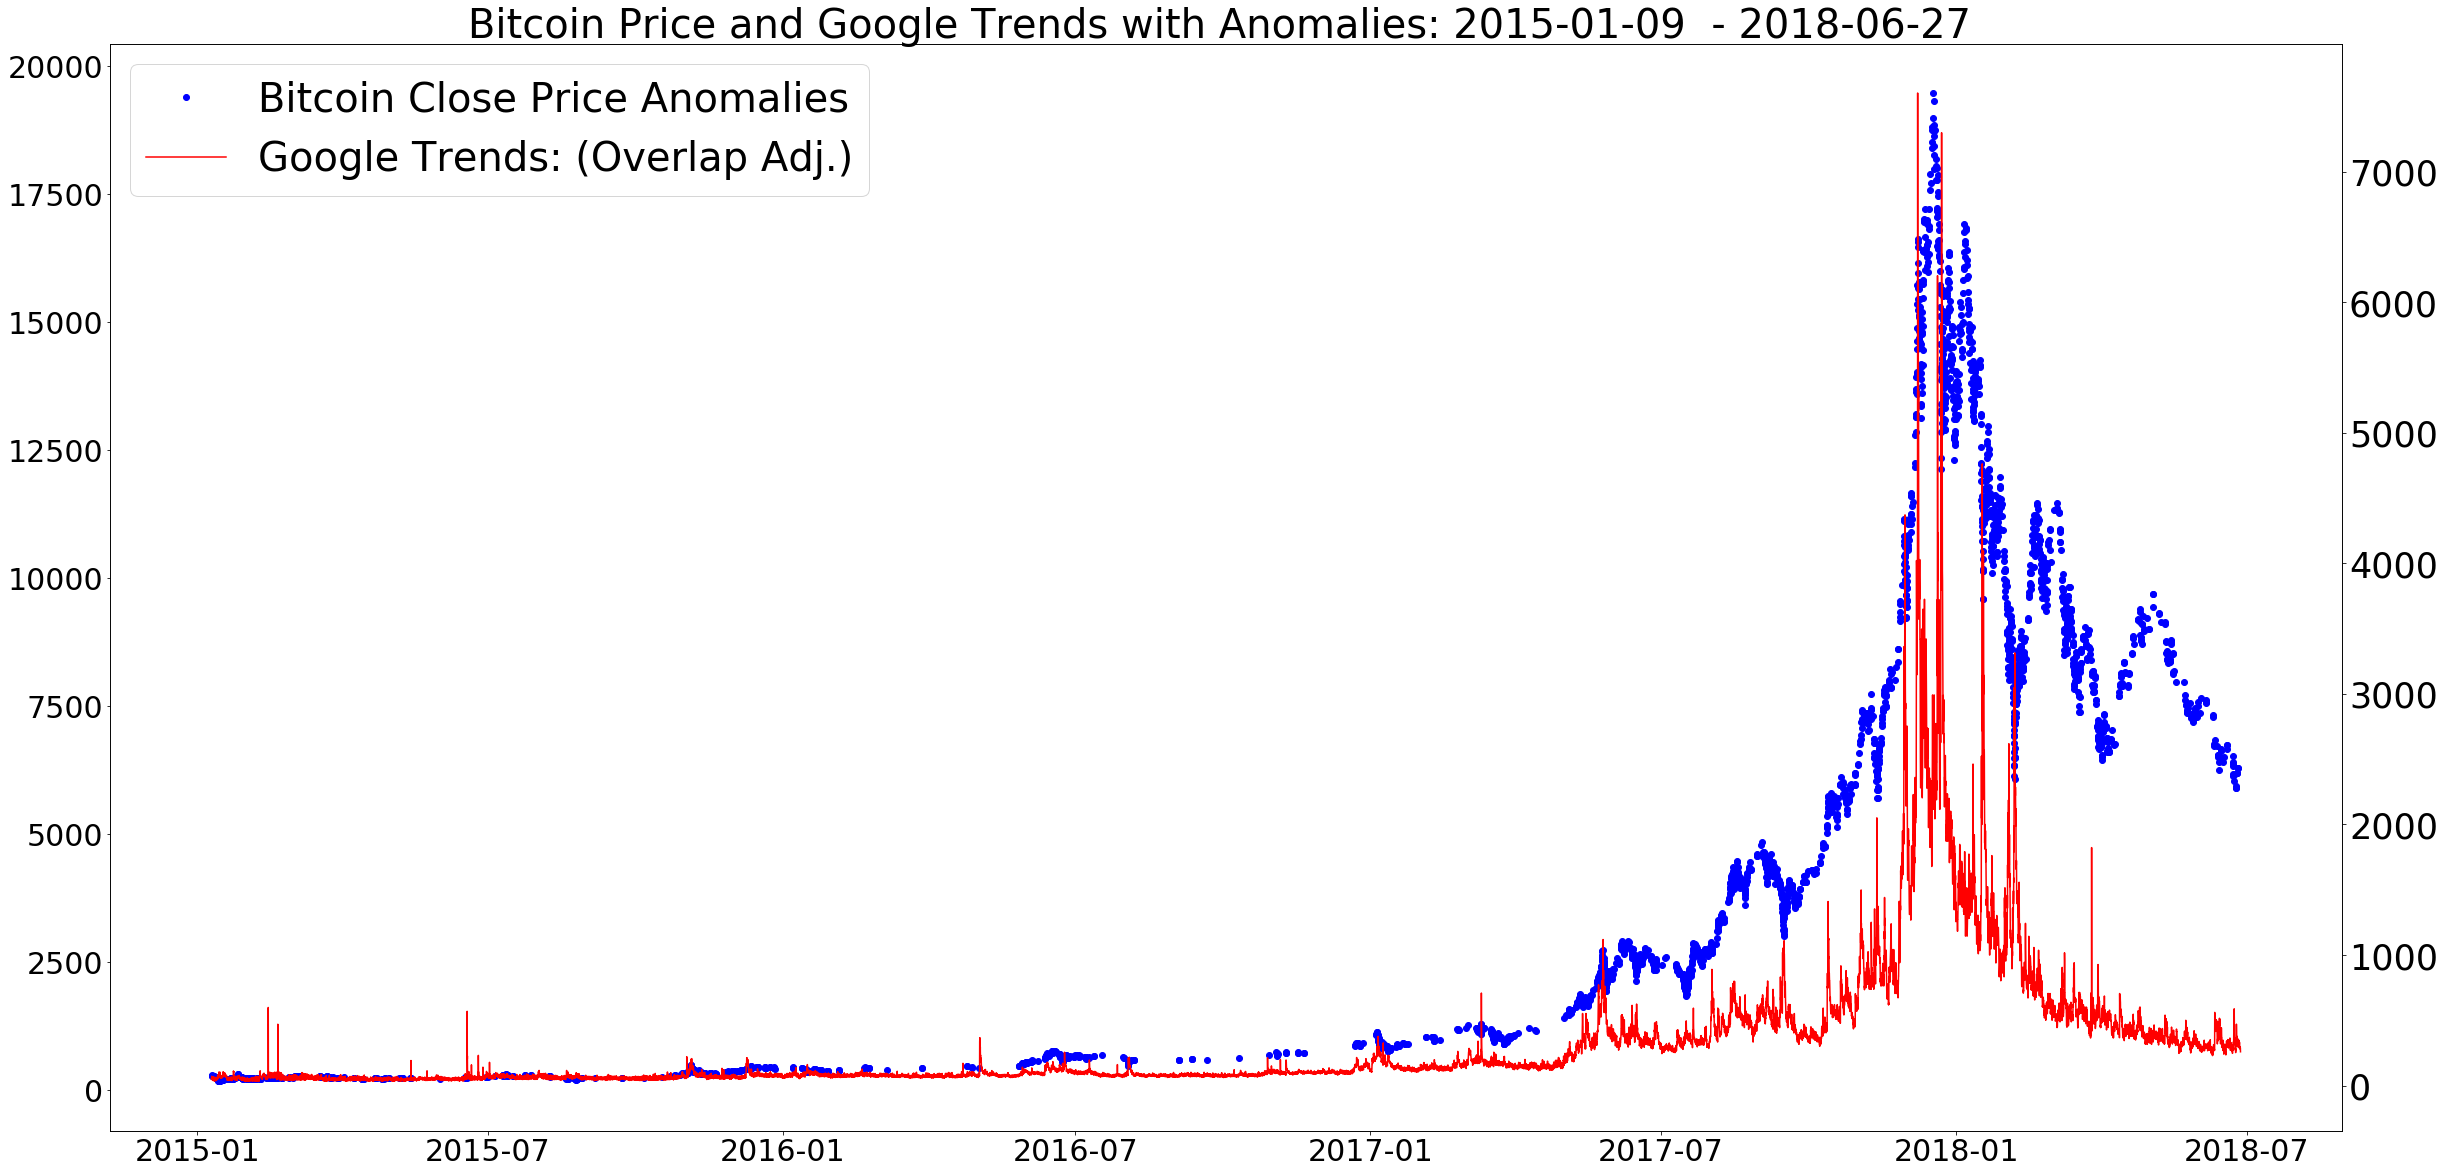

In [9]:
# Approach Anomaly Detection in a simple percent change approach 

MOVING_WINDOW_SIZE = 3

btc_and_trends_df_hourly_overlap['Moving Average Price'] = btc_and_trends_df_hourly_overlap["Close"].rolling(window=MOVING_WINDOW_SIZE).mean()
btc_and_trends_df_hourly_overlap["Moving Average Price % Change"] = btc_and_trends_df_hourly_overlap["Moving Average Price"].pct_change()
btc_and_trends_df_hourly_overlap["MA % Change (Abs.Value)"] = btc_and_trends_df_hourly_overlap["Moving Average Price % Change"].abs() 

THRESHOLD_PERCENTILE = 0.9 

threshold_cutoff_value = btc_and_trends_df_hourly_overlap["MA % Change (Abs.Value)"].quantile(THRESHOLD_PERCENTILE)
print('With a Percentile threshold of %f, the cutoff value is %f' %(THRESHOLD_PERCENTILE, threshold_cutoff_value) )

above_threshold_df = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["MA % Change (Abs.Value)"] >= threshold_cutoff_value]
display(above_threshold_df.head())
print('There are %i rows above threshold' % (len(above_threshold_df)))
display(btc_and_trends_df_hourly_overlap.tail())


# Graph it 
fig, ax = plt.subplots(figsize=(40,20)) 
l1, = ax.plot(above_threshold_df["Date(UTC)"], above_threshold_df["Close"], color='blue',linestyle="None", marker='o')
#l2, = ax.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Close"], color='#aad6cc')

ax2 = ax.twinx() 
l3, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )

ax.set_title('Bitcoin Price and Google Trends with Anomalies: ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
for tick in ax.get_xticklabels():
    tick.set_fontsize(30)
for tick in ax.get_yticklabels():
    tick.set_fontsize(30)  

#plt.legend([l1, l2, l3],["Bitcoin Close Price Anomalies", "Bitcoin Close Price ", "Google Trends: (Overlap Adj.)"], fontsize=40)
plt.legend([l1, l3],["Bitcoin Close Price Anomalies", "Google Trends: (Overlap Adj.)"], fontsize=40)

plt.show();



In [10]:
# Label the top X% of percent changes as 1, bottom X% as -1, and all the others as 0

THRESHOLD_PERCENTILE = 0.3

upper_threshold_cutoff_value = btc_and_trends_df_hourly_overlap["Close Price % Change"].quantile(1-THRESHOLD_PERCENTILE)
lower_threshold_cutoff_value = btc_and_trends_df_hourly_overlap["Close Price % Change"].quantile(THRESHOLD_PERCENTILE)
print('With a Percentile threshold of %f, the cutoff value is %f' %(1-THRESHOLD_PERCENTILE, upper_threshold_cutoff_value) )
print('With a Percentile threshold of %f, the cutoff value is %f' %(THRESHOLD_PERCENTILE, lower_threshold_cutoff_value) )

# Change to label data 
above_upper_threshold_df = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["Close Price % Change"] >= upper_threshold_cutoff_value]
display(above_upper_threshold_df.head())
print('There are %i rows above upper threshold' % (len(above_upper_threshold_df)))

below_lower_threshold_df = btc_and_trends_df_hourly_overlap[btc_and_trends_df_hourly_overlap["Close Price % Change"] <= lower_threshold_cutoff_value]
display(below_lower_threshold_df.head())
print('There are %i rows belo lower threshold' % (len(below_lower_threshold_df)))


# Initialize "Is Spike" Column
# 1 for positive spike, 0 for normal, -1 for negative spike
btc_and_trends_df_hourly_overlap['Is Spike'] = 0 

btc_and_trends_df_hourly_overlap.loc[btc_and_trends_df_hourly_overlap["Close Price % Change"] >= upper_threshold_cutoff_value, 'Is Spike'] = 1 
btc_and_trends_df_hourly_overlap.loc[btc_and_trends_df_hourly_overlap["Close Price % Change"] <= lower_threshold_cutoff_value, 'Is Spike'] = -1

display(btc_and_trends_df_hourly_overlap.head())

With a Percentile threshold of 0.700000, the cutoff value is 0.002158
With a Percentile threshold of 0.300000, the cutoff value is -0.001781


Timestamp    Open    High     Low   Close  Volume_(BTC)  \
1   1420844400  293.61  293.61  292.15  292.15     36.628012   
2   1420848000  293.89  293.89  293.89  293.89      0.158015   
6   1420862400  288.38  288.38  288.37  288.37      0.575908   
7   1420866000  290.25  290.66  290.25  290.27      2.315487   
19  1420909200  278.95  278.99  278.80  278.99      3.676898   

    Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
1        10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   
2           46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 19:00:00   
6          166.078412      288.376527 2015-01-10 04:00:00 2015-01-09 23:00:00   
7          672.622449      290.488546 2015-01-10 05:00:00 2015-01-10 00:00:00   
19        1025.443794      278.888296 2015-01-10 17:00:00 2015-01-10 12:00:00   

    Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
1                    52.0      False 2015-01-09 23:00:00+00:00   
2                    52.0      False 2015-01-10 00:00:00+00:00   
6                    62.0      False 2015-01-10 04:00:00+00:00   
7                    60.0      False 2015-01-10 05:00:00+00:00   
19                   40.0      False 2015-01-10 17:00:00+00:00   

    Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
1                 52              0.010445                    0.010445   
2                 52              0.005956                    0.005956   
6                 62              0.005825                    0.005825   
7                 60              0.006589                    0.006589   
19                40              0.010138                    0.010138   

    Moving Average Price  Moving Average Price % Change  \
1                    NaN                            NaN   
2             291.723333                            NaN   
6             287.886667                      -0.000845   
7             288.446667                       0.001945   
19            277.560000                       0.002335   

    MA % Change (Abs.Value)  
1                       NaN  
2                       NaN  
6                  0.000845  
7                  0.001945  
19                 0.002335

There are 9089 rows above upper threshold


Timestamp    Open    High     Low   Close  Volume_(BTC)  \
3   1420851600  289.20  289.20  289.10  289.10     30.985828   
5   1420858800  286.66  286.98  286.65  286.70    501.942237   
8   1420869600  288.61  288.62  288.61  288.62     11.221734   
9   1420873200  286.70  286.70  286.70  286.70      0.924500   
10  1420876800  285.80  285.80  285.80  285.80      0.130916   

    Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
3         8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 20:00:00   
5       143886.762160      286.660001 2015-01-10 03:00:00 2015-01-09 22:00:00   
8         3238.709911      288.610471 2015-01-10 06:00:00 2015-01-10 01:00:00   
9          265.054150      286.700000 2015-01-10 07:00:00 2015-01-10 02:00:00   
10          37.415744      285.800000 2015-01-10 08:00:00 2015-01-10 03:00:00   

    Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
3                    56.0      False 2015-01-10 01:00:00+00:00   
5                    72.0      False 2015-01-10 03:00:00+00:00   
8                    57.0      False 2015-01-10 06:00:00+00:00   
9                    59.0      False 2015-01-10 07:00:00+00:00   
10                   59.0      False 2015-01-10 08:00:00+00:00   

    Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
3                 56             -0.016299                    0.016299   
5                 72             -0.006549                    0.006549   
8                 57             -0.005684                    0.005684   
9                 59             -0.006652                    0.006652   
10                59             -0.003139                    0.003139   

    Moving Average Price  Moving Average Price % Change  \
3             291.713333                      -0.000034   
5             288.130000                      -0.008249   
8             289.086667                       0.002219   
9             288.530000                      -0.001926   
10            287.040000                      -0.005164   

    MA % Change (Abs.Value)  
3                  0.000034  
5                  0.008249  
8                  0.002219  
9                  0.001926  
10                 0.005164

There are 9089 rows belo lower threshold


Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0  1420840800  289.59  289.94  289.13  289.13     34.042422   
1  1420844400  293.61  293.61  292.15  292.15     36.628012   
2  1420848000  293.89  293.89  293.89  293.89      0.158015   
3  1420851600  289.20  289.20  289.10  289.10     30.985828   
4  1420855200  289.18  289.18  288.57  288.59      7.694195   

   Volume_(Currency)  Weighted_Price           Date(UTC)                date  \
0        9854.490388      289.476771 2015-01-09 22:00:00 2015-01-09 17:00:00   
1       10733.474257      293.040042 2015-01-09 23:00:00 2015-01-09 18:00:00   
2          46.439149      293.890000 2015-01-10 00:00:00 2015-01-09 19:00:00   
3        8960.344674      289.175573 2015-01-10 01:00:00 2015-01-09 20:00:00   
4        2224.105007      289.062740 2015-01-10 02:00:00 2015-01-09 21:00:00   

   Bitcoin (Adj.Overlap)  isPartial            Date_UTC_trend  \
0                   53.0      False 2015-01-09 22:00:00+00:00   
1                   52.0      False 2015-01-09 23:00:00+00:00   
2                   52.0      False 2015-01-10 00:00:00+00:00   
3                   56.0      False 2015-01-10 01:00:00+00:00   
4                   53.0      False 2015-01-10 02:00:00+00:00   

   Bitcoin (Unadj.)  Close Price % Change  Close Price % Change (Abs)  \
0                53                   NaN                         NaN   
1                52              0.010445                    0.010445   
2                52              0.005956                    0.005956   
3                56             -0.016299                    0.016299   
4                53             -0.001764                    0.001764   

   Moving Average Price  Moving Average Price % Change  \
0                   NaN                            NaN   
1                   NaN                            NaN   
2            291.723333                            NaN   
3            291.713333                      -0.000034   
4            290.526667                      -0.004068   

   MA % Change (Abs.Value)  Is Spike  
0                      NaN         0  
1                      NaN         1  
2                      NaN         1  
3                 0.000034        -1  
4                 0.004068         0

In [11]:
# correlation

corr_close_and_overlap = btc_and_trends_df_hourly_overlap["Close"].corr(btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"])

print('Correlation between Close price and Trend (Overlap): ', corr_close_and_overlap)


Correlation between Close price and Trend (Overlap):  0.814877401923


## Structural VAR and Granger Causality

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Process Data 
granger_df = btc_and_trends_df_hourly_overlap[["Close", "Bitcoin (Adj.Overlap)","Close Price % Change (Abs)" ]]
granger_df = granger_df.dropna()
display(granger_df.head())

# turn data from non-stationary to stationary data

granger_df["Close Price % Change (Abs)"].loc[granger_df["Close Price % Change (Abs)"] == 0.000000] = 0.000001
granger_df["Bitcoin % Change (Abs)"] = abs(granger_df["Bitcoin (Adj.Overlap)"].pct_change() )
granger_df["Bitcoin % Change (Abs)"].loc[granger_df["Bitcoin % Change (Abs)"] == 0.000000] = 0.000001

close_price_volatility = granger_df["Close Price % Change (Abs)"]
trends_volatility = granger_df["Bitcoin % Change (Abs)"] 

data_matrix_array = np.diff(np.log(granger_df), axis=0)

data_matrix = pd.DataFrame(data_matrix_array, columns = ["Close", "Bitcoin (Adj.Overlap)","Close Price % Change (Abs)","Bitcoin % Change (Abs)" ])
data_matrix["Bitcoin (Adj.Overlap)"].loc[data_matrix["Bitcoin (Adj.Overlap)"] == 0.000000] = 0.000001
data_matrix["Close Price % Change (Abs)"].loc[data_matrix["Close Price % Change (Abs)"] == 0.000000] = 0.000001
data_matrix["Bitcoin % Change (Abs)"].loc[data_matrix["Bitcoin % Change (Abs)"] == 0.000000] = 0.000001

data_matrix["Price Volatility"] = close_price_volatility 
data_matrix["Google Trends Volatility"] =  trends_volatility 

data_matrix.dropna(inplace=True)

#data_matrix = data_matrix.dropna()
print("Transformed Data")
display(data_matrix.head())

Close  Bitcoin (Adj.Overlap)  Close Price % Change (Abs)
1  292.15                   52.0                    0.010445
2  293.89                   52.0                    0.005956
3  289.10                   56.0                    0.016299
4  288.59                   53.0                    0.001764
5  286.70                   72.0                    0.006549

Transformed Data


Close  Bitcoin (Adj.Overlap)  Close Price % Change (Abs)  \
2 -0.001766              -0.055060                   -2.223442   
3 -0.006571               0.306374                    1.311687   
4  0.005808              -0.149532                   -0.117183   
5  0.006567              -0.032790                    0.123222   
6 -0.005701              -0.051293                   -0.147646   

   Bitcoin % Change (Abs)  Price Volatility  Google Trends Volatility  
2               -0.361790          0.005956                  0.000001  
3                1.900886          0.016299                  0.076923  
4               -0.948228          0.001764                  0.053571  
5               -1.459906          0.006549                  0.358491  
6                0.438255          0.005825                  0.138889

In [30]:
# writer = pd.ExcelWriter("data_matrix.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# data_matrix.to_excel(writer)
# writer.save()

In [31]:
# Test if data is now stationary using Augmented Dickey-Fuller unit root test (Adfuller)

cols = ['Close','Bitcoin (Adj.Overlap)',"Close Price % Change (Abs)"  ]

results = [] 

for col in cols: 
    results.append(adfuller(granger_df[col].values, regression='nc'))
results.append(adfuller(granger_df["Bitcoin % Change (Abs)" ].iloc[1:].values, regression='nc'))

for col in cols: 
    results.append(adfuller(data_matrix[col], regression='nc'))
results.append(adfuller(data_matrix["Bitcoin % Change (Abs)" ].iloc[1:], regression='nc'))


results_labels = ['Price with w/o difference', 'Bitcoin trend w/o difference', 'Close Price % Change (Abs) w/o difference', 'Bitcoin % Change (Abs) w/o change',          
                  'Price with w/ difference', 'Bitcoin trend w/ difference', 'Close Price % Change (Abs) w/ difference', 'Bitcoin % Change (Abs) w/ change']

for i, result in enumerate(results):
    print('-----------------------')
    print(results_labels[i])              
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


-----------------------
Price with w/o difference
ADF Statistic: -0.702816
p-value: 0.411424
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
-----------------------
Bitcoin trend w/o difference
ADF Statistic: -4.290599
p-value: 0.000023
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
-----------------------
Close Price % Change (Abs) w/o difference
ADF Statistic: -6.686690
p-value: 0.000000
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
-----------------------
Bitcoin % Change (Abs) w/o change
ADF Statistic: -6.524511
p-value: 0.000000
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
-----------------------
Price with w/ difference
ADF Statistic: -32.364454
p-value: 0.000000
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
-----------------------
Bitcoin trend w/ difference
ADF Statistic: -28.530366
p-value: 0.000000
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
-----------------------
Close Price % Change (Abs) w/ difference
ADF Statistic: -37.7393

Close  Bitcoin (Adj.Overlap)  Close Price % Change (Abs)  \
2 -0.001766              -0.055060                   -2.223442   
3 -0.006571               0.306374                    1.311687   
4  0.005808              -0.149532                   -0.117183   
5  0.006567              -0.032790                    0.123222   
6 -0.005701              -0.051293                   -0.147646   

   Bitcoin % Change (Abs)  Price Volatility  Google Trends Volatility  
2               -0.361790          0.005956                  0.000001  
3                1.900886          0.016299                  0.076923  
4               -0.948228          0.001764                  0.053571  
5               -1.459906          0.006549                  0.358491  
6                0.438255          0.005825                  0.138889

array([['1', 'E'],
       ['0', '1']], 
      dtype='<U11')

array([['E', '0'],
       ['0', 'E']], 
      dtype='<U1')

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 24, Aug, 2018
Time:                     21:55:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.5758
Nobs:                     30212.0    HQIC:                  -14.6289
Log likelihood:           135910.    FPE:                4.32359e-07
AIC:                     -14.6540    Det(Omega_mle):     4.28323e-07
--------------------------------------------------------------------
Results for equation Close
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
L1.Close                         -0.058738         0.005766          -10.187           0.000
L1.Bitcoin (Adj.Overlap)         -0.000098         0.000698           -0.140           0.888
L2.Close    

Granger Causality: Google Trend -> Close
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Close. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
    1.111          1.291       0.244  (71, 60140)
-------------------------------------------------


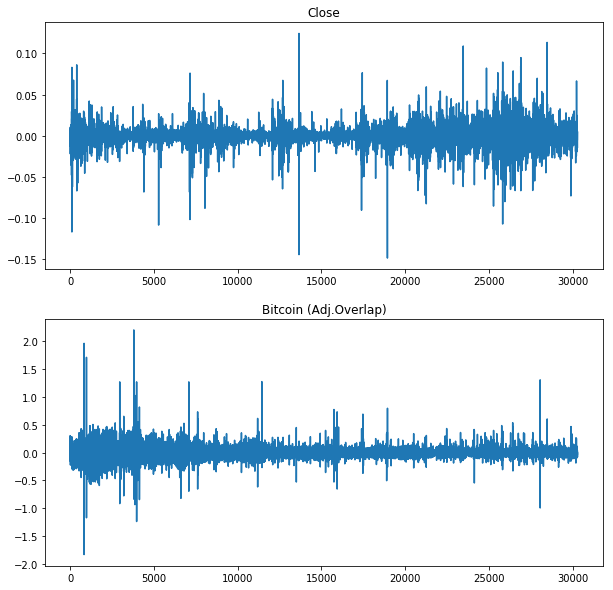

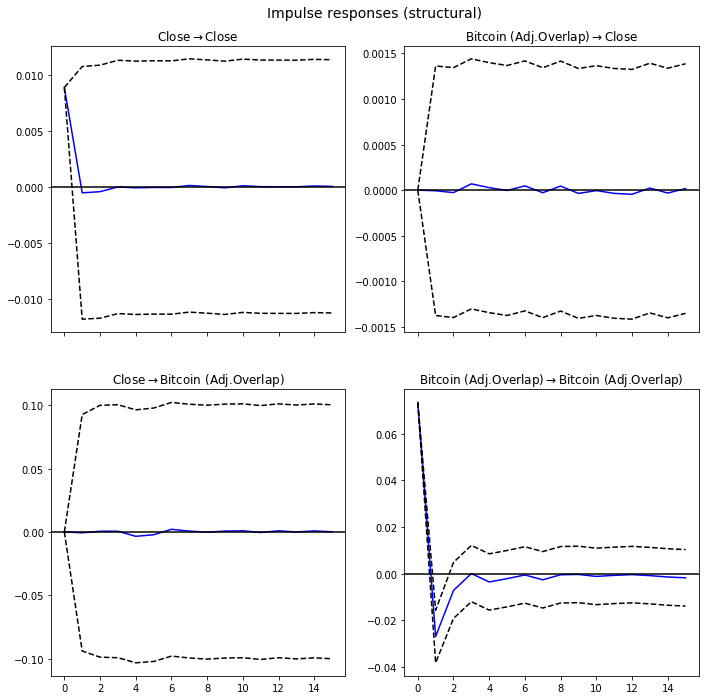

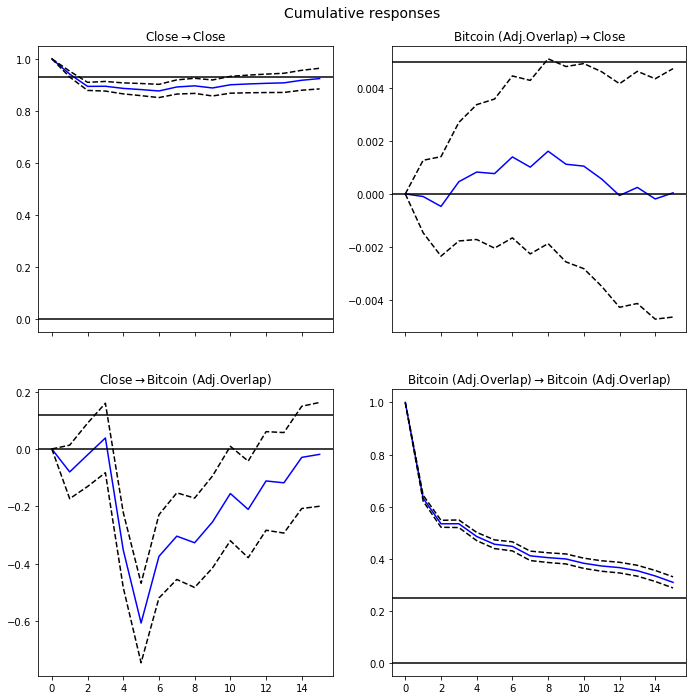

In [32]:
from statsmodels.tsa.api import SVAR 

plt.rcParams.update({'font.size':10})

"""
https://www.researchgate.net/file.PostFileLoader.html?id=514b37aed3df3e9a08000047&assetKey=AS%3A271834451251200%401441821791671

A-matrix imposes restrictions on the off-diagonal terms. 
The diagonal terms reflect the unit change of element i on i or on itself e.g. if defense spending increases
this should have a 1:1 response = you will see a 1 for diagonal terms. Same for GDP.

A = [[ i -> i,   j -> i],
     [ i -> j,   j -> j]]
       
       i.e.    i = defense spending, j = GDP
               -> 0 means no effect. so if j->i = 0, it means that GDP has no effect on defense spending

My case: 

let i = Close Price, j = Google Trends 

            A = [[ 1, 1 ]
                 ['E',1 ]]

                -> Assumption: Google Trends has 1 to 1 effect on Close Price (j->i = 1)
                               Close Price has effect on Google Trends, to be calculated (i -> j = 'E')

            A = [[ 1, 'E' ]
                 [ 1 ,1 ]]

                -> Assumption: Close Price has effect on Google Trends (i->j = 1)
                ---> Impact of Google Trends on Close Price is Estimated


****** the appropriate one ******

A = [[ 1, 'E' ]
     [ 0 ,1 ]]

    -> Assumption: Close Price has no effect on Google Trends (i->j = 0)
                   Google Trends does have an effect on Close Price (j->i = 'E')

B = [['E', 0  ],
     [ 0 ,'E']]


    -> Assumption: The covariance between two variables are unrelated and estimating the own variance.

"""

# A = np.array([[ 1 , 1], 
#               ['E', 1]])
# A = np.array([[ 1 , 'E'], 
#               [1, 1]])

A = np.array([[ 1, 'E'],
              [ 0 , 1 ]])

B = np.array([['E',0], 
              [0, 'E']])

display(data_matrix.head(), A, B )

SVAR_model = SVAR(data_matrix[["Close", "Bitcoin (Adj.Overlap)"]], svar_type='AB', A=A, B=B)
result_SVAR = SVAR_model.fit(verbose=True, trend='nc', maxlags=71) # 71 somehow causes the smallest p-value
display(result_SVAR.summary())

result_SVAR.plot();
SVAR_irf = result_SVAR.irf(periods=15)
SVAR_irf.plot();
SVAR_irf.plot_cum_effects();

SVAR_granger_result = result_SVAR.test_causality(caused='Close', causing='Bitcoin (Adj.Overlap)', kind='f')
print('Granger Causality: Google Trend -> Close')
print(SVAR_granger_result.summary())

- AIC: Akaike Information Criterion - estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.
- BIC: Bayesian Information Criterion - criterion for model selection among a finite set of models
- HQIC: Hannan–Quinn information criterion - Another criterion for Model Selection
    - Smaller the better 


- FPE: Final Prediction Error - Akaike's Final Prediction Error (FPE) criterion provides a measure of model quality by simulating the situation where the model is tested on a different data set. 

- DEt(Omega_mle): ?? MLE = Maximum Likelihood Estimation


In [33]:
# Test if Prices Granger Causes Trend 
SVAR_granger_result_2 = result_SVAR.test_causality(caused='Bitcoin (Adj.Overlap)', causing='Close', kind='f')
print('Granger Causality: Close -> Google Trend')
print(SVAR_granger_result_2.summary())

Granger Causality: Close -> Google Trend
Granger causality F-test. H_0: Close does not Granger-cause Bitcoin (Adj.Overlap). Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
    2.741          1.291       0.000  (71, 60140)
-------------------------------------------------


C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 24, Aug, 2018
Time:                     21:55:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.1297
Nobs:                     30275.0    HQIC:                  -15.1357
Log likelihood:           143275.    FPE:                2.66332e-07
AIC:                     -15.1385    Det(Omega_mle):     2.66051e-07
--------------------------------------------------------------------
Results for equation Price Volatility
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
L1.Price Volatility              0.161810         0.005719           28.292           0.000
L1.Bitcoin (Adj.Overlap)         0.003604         0.000457            7.891           0.000
L2.Pr

-----------------------------------------------------
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Price Volatility. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    37.87          1.939       0.000  (8, 60518)
------------------------------------------------


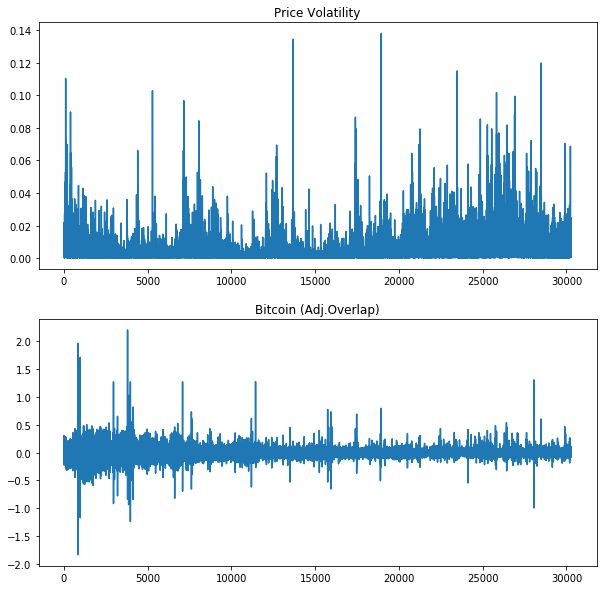

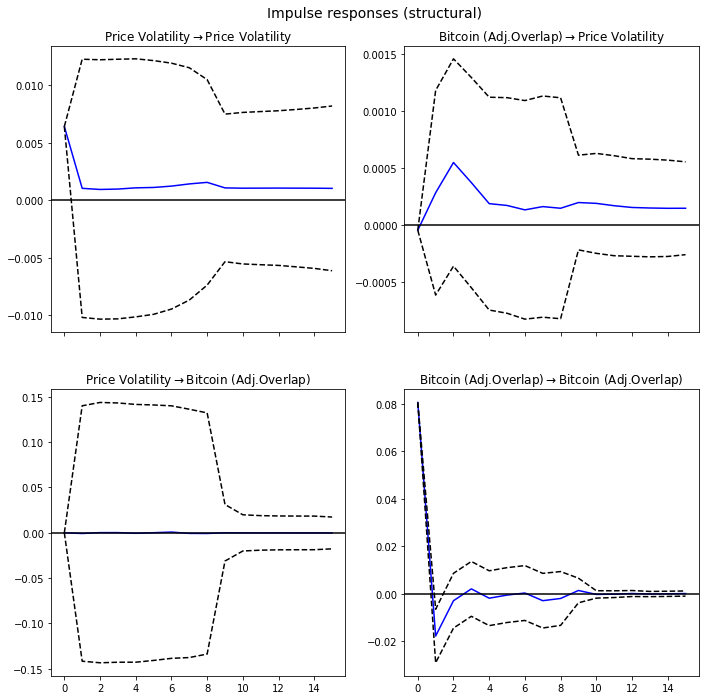

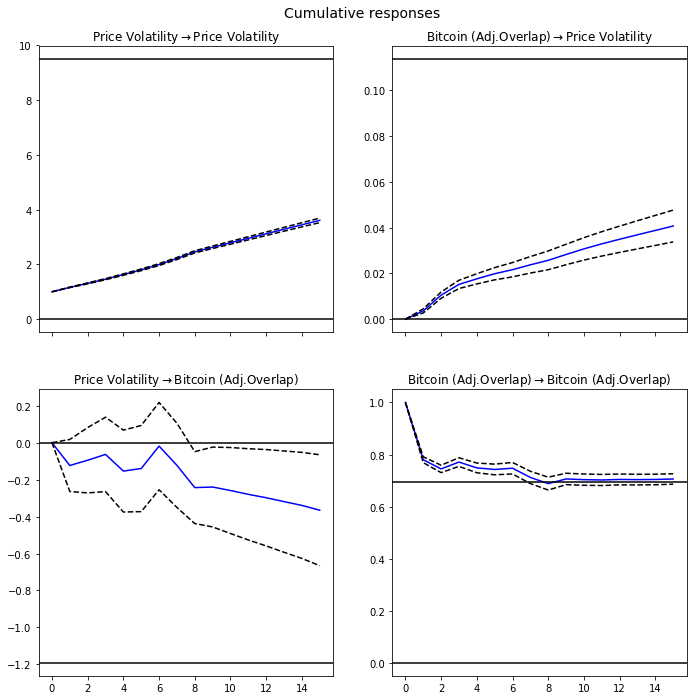

In [34]:
# Run SVAR for price % change

SVAR_model_percent_change = SVAR(data_matrix[["Price Volatility", "Bitcoin (Adj.Overlap)"]], svar_type='AB', A=A, B=B)
percent_change_result_SVAR = SVAR_model_percent_change.fit(verbose=True, trend='nc',maxlags=8)

# NOTE: ERROR HAPPENS PROBABLY FROM 0s IN THE DATA 

display(percent_change_result_SVAR.summary())
percent_change_result_SVAR.plot();
SVAR_irf_percent_change = percent_change_result_SVAR.irf(periods=15)
SVAR_irf_percent_change.plot();
SVAR_irf_percent_change.plot_cum_effects();

SVAR_granger_percent_change_result = percent_change_result_SVAR.test_causality('Price Volatility', 'Bitcoin (Adj.Overlap)', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_percent_change_result.summary())

***** out of date because my graph changed

- Interpretations of Price % Change Version 
    - In Granger Causality test, the p-value for if Google Trends Granger causes Close Price % Change is 0.001 and
    the test statistic is greater than the critical value. Thus, the null hypothesis that there is no granger causality is rejected 
    - Impulse Response
        - Bitcoin (Adj. Overlap) -> Close Price % Change (Abs)
            - If Google Trends receives positive shock, Price % Change responds positively in the first 30 minutes, then fall to a negative response by the end of the 1st hour. Then, it will come back to plateu starting hour 3
            - Question: What does it mean that it responds negatively when the close price % change was originally just all absolute values before the data transformations? (log differences)
                -> It means that this is just showing volatility
        - Close Price % Change (Abs) -> Bitcoin (Adj. Overlap)
            - If Price % Change receives a positive shock, Google Trends will at first respond negatively for the first hour, then come up to normal by the end of the 2nd hour
    - Cumulative Impulse Response 
        - Bitcoin (Adj. Overlap) -> Close Price % Change (Abs)
            - Roughly after 30 minutes of a positive shock given to Google Trends, Price % Change goes up and eventually end up at a higher level than before
        - Close Price % Change (Abs) -> Bitcoin (Adj. Overlap)
            - Roughly 1 hour after a positive shock given to Price % Change, Google Trends responds negatively, but at a very miniscule scale
           

In [35]:
SVAR_granger_percent_change_result_2 = percent_change_result_SVAR.test_causality('Bitcoin (Adj.Overlap)','Price Volatility',kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_percent_change_result_2.summary())

-----------------------------------------------------
Granger causality F-test. H_0: Price Volatility does not Granger-cause Bitcoin (Adj.Overlap). Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    2.083          1.939       0.034  (8, 60518)
------------------------------------------------


C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 24, Aug, 2018
Time:                     21:56:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.8480
Nobs:                     30232.0    HQIC:                  -14.8854
Log likelihood:           139679.    FPE:                3.37056e-07
AIC:                     -14.9030    Det(Omega_mle):     3.34837e-07
--------------------------------------------------------------------
Results for equation Price Volatility
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
L1.Price Volatility                  0.121899         0.005761           21.161           0.000
L1.Google Trends Volatility          0.000263         0.000395            0.666      

-----------------------------------------------------
Granger causality F-test. H_0: Google Trends Volatility does not Granger-cause Price Volatility. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
    1.667          1.350       0.002  (50, 60264)
-------------------------------------------------


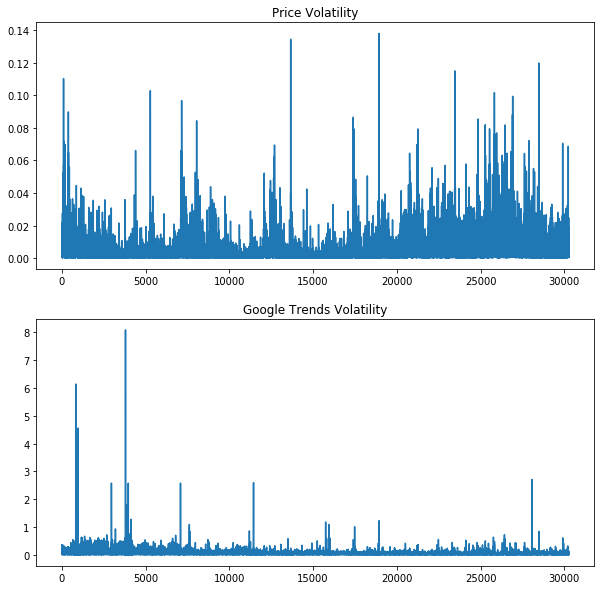

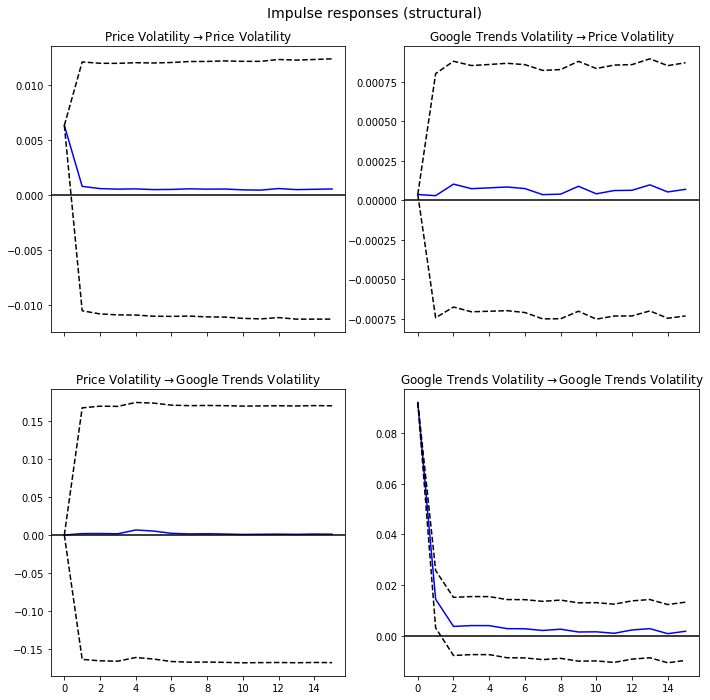

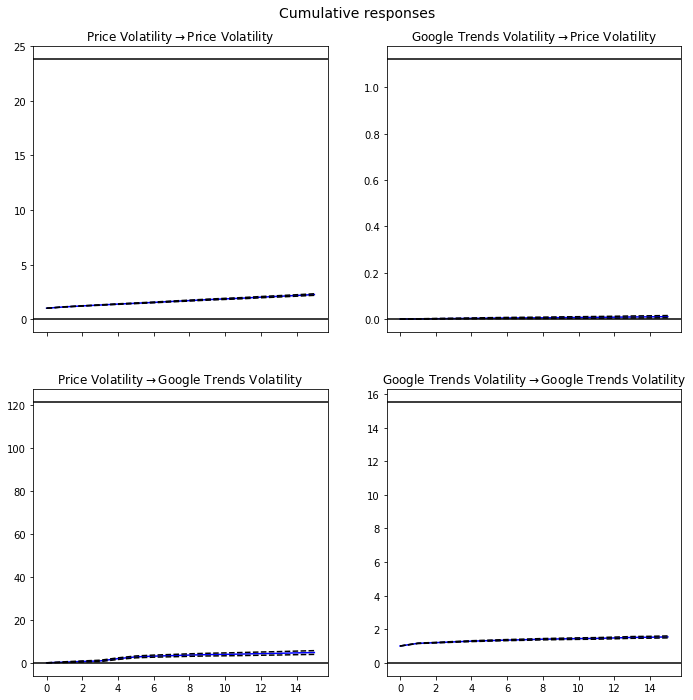

In [36]:
# Run SVAR for Trend % change

SVAR_model_trend_change = SVAR(data_matrix[["Price Volatility","Google Trends Volatility"]].iloc[1:], svar_type='AB', A=A, B=B)
trend_change_result_SVAR = SVAR_model_trend_change.fit(verbose=True, trend='nc', maxlags=50)

# NOTE: ERROR HAPPENS PROBABLY FROM 0s IN THE DATA 

display(trend_change_result_SVAR.summary())
trend_change_result_SVAR.plot();
SVAR_irf_trend_percent_change = trend_change_result_SVAR.irf(periods=15)
SVAR_irf_trend_percent_change.plot();
SVAR_irf_trend_percent_change.plot_cum_effects();

SVAR_granger_trend_percent_change_result = trend_change_result_SVAR.test_causality('Price Volatility', 'Google Trends Volatility', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_trend_percent_change_result.summary())

In [37]:
SVAR_granger_trend_percent_change_result_2 = trend_change_result_SVAR.test_causality( 'Google Trends Volatility','Price Volatility', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_trend_percent_change_result_2.summary())

-----------------------------------------------------
Granger causality F-test. H_0: Price Volatility does not Granger-cause Google Trends Volatility. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
    5.877          1.350       0.000  (50, 60264)
-------------------------------------------------


C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 24, Aug, 2018
Time:                     21:56:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.00277
Nobs:                     3413.00    HQIC:                  -5.16450
Log likelihood:          -578.976    FPE:                 0.00522434
AIC:                     -5.25444    Det(Omega_mle):      0.00501646
--------------------------------------------------------------------
Results for equation Close Price % Change (Abs)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
L1.Close Price % Change (Abs)         -0.972559         0.017296          -56.230           0.000
L1.Bitcoin (Adj.Overlap)               0.676883         0.400806     

-----------------------------------------------------
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Close Price % Change (Abs). Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    2.141          1.425       0.000  (35, 6686)
------------------------------------------------


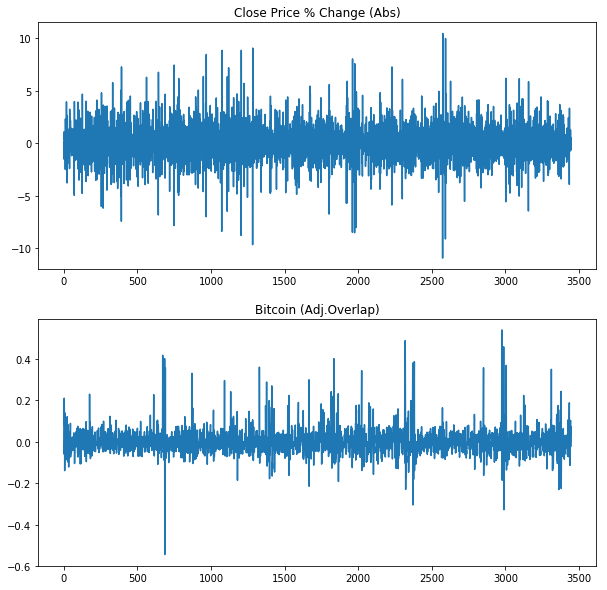

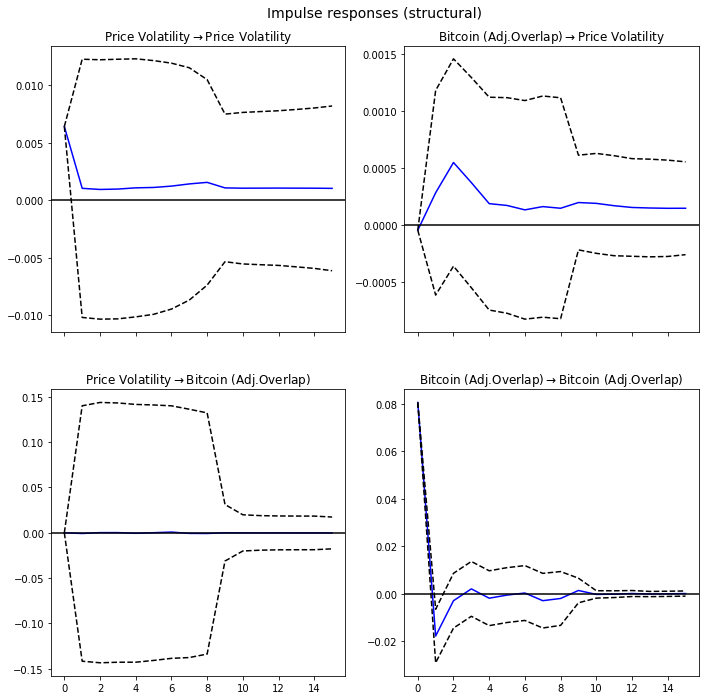

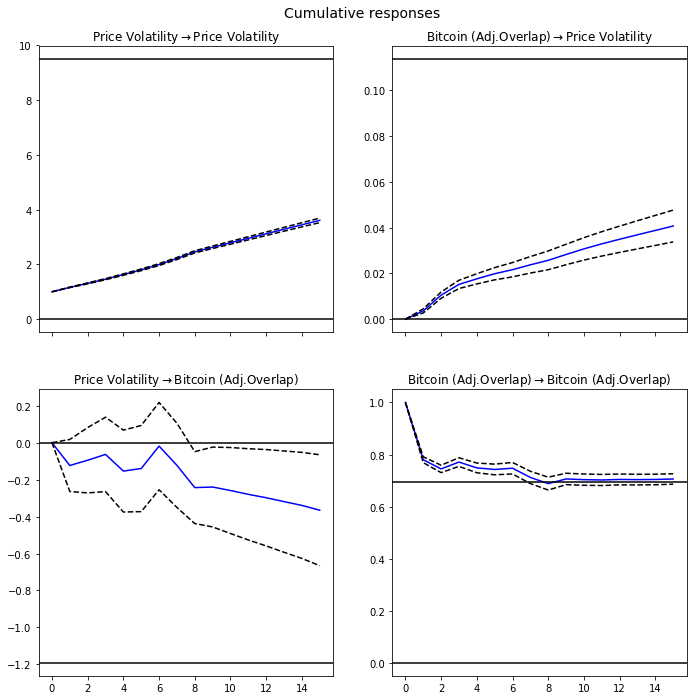

In [38]:
# see if SVAR works for sep_2017_to_feb_2018_overlap_df

# for Price % Change

# get row indexes for sep 2017 to feb 2018 
sep_2017_index = sep_2017_to_feb_2018_overlap_df.iloc[0].name 
feb_2018_index = sep_2017_to_feb_2018_overlap_df.iloc[-1].name 

SVAR_model_spike = SVAR(data_matrix[["Close Price % Change (Abs)", "Bitcoin (Adj.Overlap)"]].iloc[sep_2017_index:feb_2018_index], svar_type='AB', A=A, B=B)
spike_result_SVAR = SVAR_model_spike.fit(verbose=True, trend='nc', maxlags=35)

display(spike_result_SVAR.summary())
spike_result_SVAR.plot();
SVAR_irf_spike = percent_change_result_SVAR.irf(periods=15)
SVAR_irf_spike.plot();
SVAR_irf_spike.plot_cum_effects();

SVAR_granger_spike_result = spike_result_SVAR.test_causality('Close Price % Change (Abs)', 'Bitcoin (Adj.Overlap)', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_spike_result.summary())


In [39]:
SVAR_granger_spike_result_2= spike_result_SVAR.test_causality('Bitcoin (Adj.Overlap)','Close Price % Change (Abs)',  kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_spike_result_2.summary())

-----------------------------------------------------
Granger causality F-test. H_0: Close Price % Change (Abs) does not Granger-cause Bitcoin (Adj.Overlap). Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
    4.153          1.425       0.000  (35, 6686)
------------------------------------------------


In [42]:
# Preprocess data for price % changes without absolute values 

# NOTE: cut this part out because these values are already stationary 

price_change_df= btc_and_trends_df_hourly_overlap[['Close Price % Change', "Bitcoin (Adj.Overlap)"]]
price_change_df = price_change_df.dropna()
#price_change_stationary = np.diff(price_change_df, axis=0) 

price_change_stationary_df = pd.DataFrame(price_change_df.values, columns = ["Close Price % Change", "Bitcoin (Adj.Overlap)"])
price_change_stationary_df["Bitcoin (Adj.Overlap)"] = data_matrix["Bitcoin (Adj.Overlap)"]
price_change_stationary_df.dropna(inplace=True)

display(price_change_stationary_df.head())

adf_results = []
adf_results.append(adfuller(price_change_df['Close Price % Change']))
adf_results.append(adfuller(price_change_df['Bitcoin (Adj.Overlap)']))
adf_results.append(adfuller(price_change_stationary_df['Close Price % Change']))
adf_results.append(adfuller(price_change_stationary_df['Bitcoin (Adj.Overlap)']))

adf_results_labels = ['Close Price % Change w/o diff', 'Bitcoin (Adj.Overlap) w/o diff', 
                      'Close Price % Change w/ diff', 'Bitcoin (Adj.Overlap) w/ diff' ]

for i, result in enumerate(adf_results):
    print('-----------------------')
    print(adf_results_labels[i])              
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
# 0 screws with the SVAR convergence 
# price_change_stationary_df["Bitcoin (Adj.Overlap)"].loc[price_change_stationary_df["Bitcoin (Adj.Overlap)"] == 0.000000] = 0.000001 
# price_change_stationary_df['Close Price % Change'].loc[price_change_stationary_df['Close Price % Change'] == 0.000000] = 0.000001 

Close Price % Change  Bitcoin (Adj.Overlap)
2             -0.016299              -0.055060
3             -0.001764               0.306374
4             -0.006549              -0.149532
5              0.005825              -0.032790
6              0.006589              -0.051293

MissingDataError: exog contains inf or nans

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 24, Aug, 2018
Time:                     22:13:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.4781
Nobs:                     30273.0    HQIC:                  -14.4856
Log likelihood:           133444.    FPE:                5.09860e-07
AIC:                     -14.4891    Det(Omega_mle):     5.09187e-07
--------------------------------------------------------------------
Results for equation Close Price % Change
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
L1.Close Price % Change          -0.054586         0.005750           -9.494           0.000
L1.Bitcoin (Adj.Overlap)         -0.000357         0.000639           -0.559           0.5

-----------------------------------------------------
Granger causality F-test. H_0: Bitcoin (Adj.Overlap) does not Granger-cause Close Price % Change. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value      df    
-------------------------------------------------
    0.4667         1.831       0.912  (10, 60506)
-------------------------------------------------


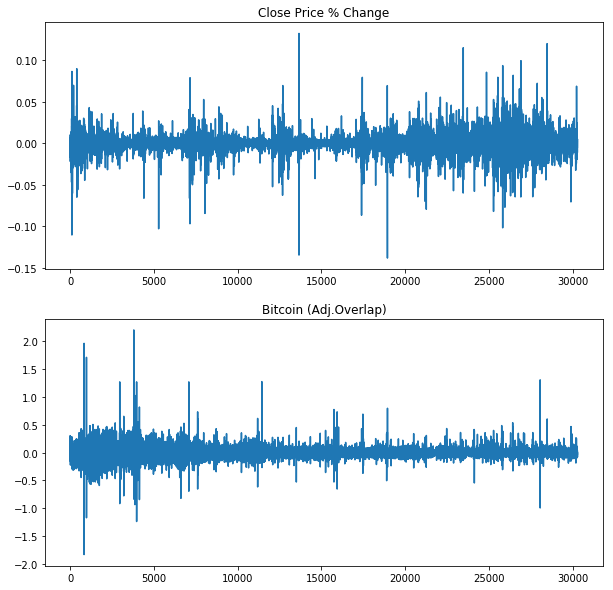

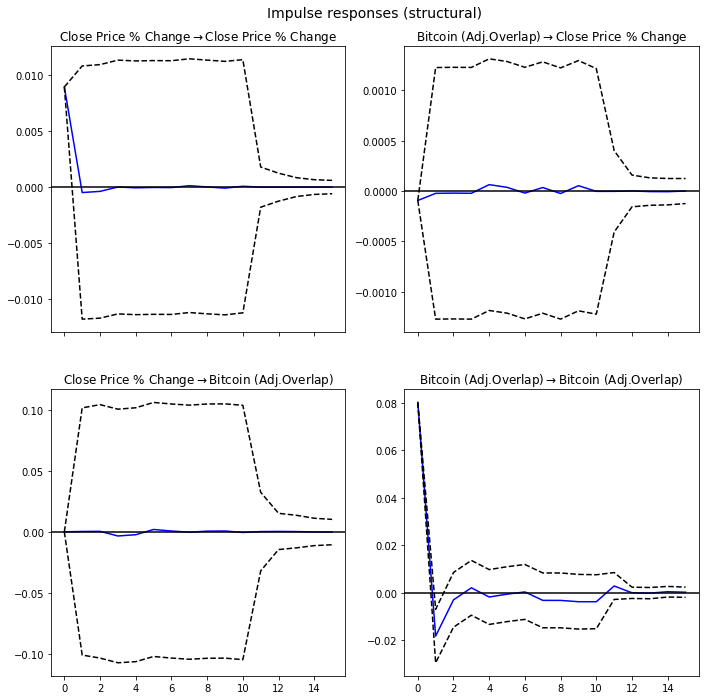

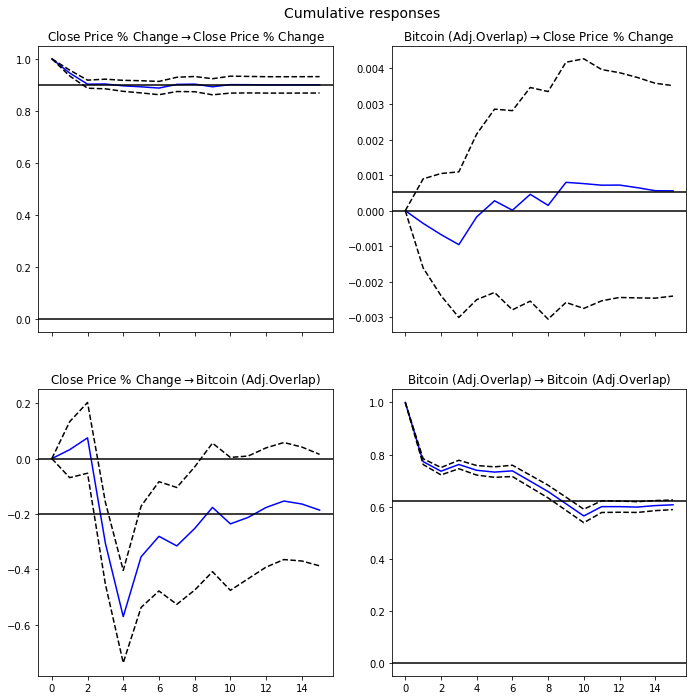

In [43]:
# Run SVAR for Price % Change w/o absolute values 

SVAR_model_price_change = SVAR(price_change_stationary_df[['Close Price % Change', 'Bitcoin (Adj.Overlap)']], svar_type='AB', A=A, B=B)
price_change_result_SVAR = SVAR_model_price_change.fit(verbose=True, trend='nc', maxlags=10)
# NOTE: ERROR HAPPENS PROBABLY FROM 0s IN THE DATA 

display(price_change_result_SVAR.summary())
price_change_result_SVAR.plot();
SVAR_irf_price_change = price_change_result_SVAR.irf(periods=15)
SVAR_irf_price_change.plot();
SVAR_irf_price_change.plot_cum_effects();

SVAR_granger_price_change_result = price_change_result_SVAR.test_causality('Close Price % Change', 'Bitcoin (Adj.Overlap)', kind='f')
print('-----------------------------------------------------')
print(SVAR_granger_price_change_result.summary())

In [ ]:
"""
Deep Learning Model to Predict Crypto Price Spike/Fall

Problem: Supervised Spike Classification

Definition of Spike (Anomaly): X% of price change ? 

Inputs
    Price % Change 
    Google Trends
    Volume
    
    Anomaly Value from Luminol ?
        Choices: for price level, price % change, google trends 

    (1 or 0 on whether there is anomaly or not from training data )

Outputs 
    1 or 0 on whether there is anomaly or not (Prediction)
    
""";


In [ ]:
writer = pd.ExcelWriter("master_df_v3.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
btc_and_trends_df_hourly_overlap.to_excel(writer)
writer.save()